# Complete Machine Learning Classification Pipeline

This notebook demonstrates a complete machine learning pipeline including:
- Data acquisition using Kaggle API
- Data processing and exploration
- Model creation and evaluation
- Model testing with comprehensive metrics
- Model retraining capabilities
- API creation for model deployment

## Dataset: Chest X-Ray Pneumonia Detection
We'll use the Chest X-Ray Pneumonia dataset for binary classification to detect pneumonia in chest X-ray images.

**Dataset Source:** https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

This dataset contains chest X-ray images organized into training, testing, and validation sets with two categories:
- **NORMAL**: Normal chest X-rays
- **PNEUMONIA**: Chest X-rays showing pneumonia

## 1. Setup and Dependencies

In [27]:
# Install required packages
!pip install kaggle pandas numpy scikit-learn matplotlib seaborn plotly joblib flask fastapi uvicorn

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Image processing libraries
import cv2
from PIL import Image
from pathlib import Path

# Utilities
import os
import json
import joblib
import warnings
from datetime import datetime
import logging
import shutil
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("📦 Key packages loaded:")
print("   • Data: pandas, numpy")
print("   • ML: scikit-learn")
print("   • Visualization: matplotlib, seaborn, plotly") 
print("   • Image processing: cv2, PIL")
print("   • Utilities: joblib, scipy")

## 2. Data Acquisition

In [29]:
# Setup Kaggle API
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Check if kaggle.json exists and is properly configured
kaggle_config_path = os.path.expanduser('~/.kaggle/kaggle.json')
data_kaggle_path = '../data/kaggle.json'

print("Checking Kaggle API configuration...")

# First, check if kaggle.json exists in the standard location
if os.path.exists(kaggle_config_path):
    print(f"✅ Found kaggle.json at: {kaggle_config_path}")
else:
    print(f"❌ kaggle.json not found at: {kaggle_config_path}")
    
    # Try to copy from data folder if it exists there
    if os.path.exists(data_kaggle_path):
        print(f"📁 Found kaggle.json in data folder, copying to proper location...")
        
        # Create .kaggle directory if it doesn't exist
        kaggle_dir = os.path.dirname(kaggle_config_path)
        os.makedirs(kaggle_dir, exist_ok=True)
        
        # Copy the file
        import shutil
        shutil.copy2(data_kaggle_path, kaggle_config_path)
        
        # Set proper permissions (important for security)
        os.chmod(kaggle_config_path, 0o600)
        print(f"✅ Copied kaggle.json to: {kaggle_config_path}")
    else:
        print(f"❌ kaggle.json not found in data folder either: {data_kaggle_path}")
        print("Please ensure your kaggle.json file is in the correct location.")

# Initialize Kaggle API
try:
    api = KaggleApi()
    api.authenticate()
    print("✅ Kaggle API authenticated successfully!")
    
    # Test the authentication by getting user info
    user_info = api.get_config_value('username')
    print(f"📝 Authenticated as: {user_info}")
    
except Exception as e:
    print(f"❌ Kaggle API authentication failed: {str(e)}")
    print("\n🔧 Troubleshooting steps:")
    print("1. Make sure kaggle.json is in ~/.kaggle/ directory")
    print("2. Verify the file contains correct username and key")
    print("3. Check file permissions (should be 600)")
    print("4. Ensure you've accepted the competition rules on Kaggle website")
    raise

Checking Kaggle API configuration...
✅ Found kaggle.json at: C:\Users\HP/.kaggle/kaggle.json
✅ Kaggle API authenticated successfully!
📝 Authenticated as: kanisathiak


In [30]:
# Download Chest X-Ray Pneumonia dataset
import zipfile
import urllib.request
import pandas as pd
from pathlib import Path

dataset_name = 'paultimothymooney/chest-xray-pneumonia'
download_path = '../data/'

# Create data directory if it doesn't exist
os.makedirs(download_path, exist_ok=True)

# Method 1: Try Kaggle API first
try:
    print("🔄 Attempting to download Chest X-Ray Pneumonia dataset via Kaggle API...")
    
    # Download the dataset using datasets API (not competition API)
    api.dataset_download_files(dataset_name, path=download_path, unzip=True)
    print("✅ Downloaded via Kaggle API")
    
    # The dataset will be extracted automatically with unzip=True

except Exception as e:
    print(f"❌ Kaggle API download failed: {str(e)}")
    print("\n🔄 Trying alternative approach...")
    
    # Method 2: Manual instructions since this is a large image dataset
    print("\n📝 Manual download instructions:")
    print("1. Go to https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")
    print("2. Click 'Download' to get the zip file")
    print(f"3. Extract the zip file to: {os.path.abspath(download_path)}")
    print("4. Ensure the folder structure is: data/chest_xray/train/, data/chest_xray/test/, data/chest_xray/val/")
    
    # Check if data was manually downloaded
    chest_xray_path = os.path.join(download_path, 'chest_xray')
    if os.path.exists(chest_xray_path):
        print("✅ Found manually downloaded chest_xray folder")
    else:
        print("❌ Please download the dataset manually and run this cell again")
        raise Exception("Dataset not found. Please download manually.")

print(f"\n📁 Dataset location: {download_path}")

# Check the dataset structure
chest_xray_path = os.path.join(download_path, 'chest_xray')
if os.path.exists(chest_xray_path):
    print("\n📋 Dataset structure:")
    for root, dirs, files in os.walk(chest_xray_path):
        level = root.replace(chest_xray_path, '').count(os.sep)
        indent = ' ' * 2 * level
        folder_name = os.path.basename(root)
        if level < 3:  # Limit depth for readability
            print(f"{indent}{folder_name}/")
            if level == 2:  # Show file counts for leaf directories
                subindent = ' ' * 2 * (level + 1)
                print(f"{subindent}({len(files)} files)")

    # Count images in each category
    train_normal = len(list(Path(chest_xray_path, 'train', 'NORMAL').glob('*.jpeg')))
    train_pneumonia = len(list(Path(chest_xray_path, 'train', 'PNEUMONIA').glob('*.jpeg')))
    test_normal = len(list(Path(chest_xray_path, 'test', 'NORMAL').glob('*.jpeg')))
    test_pneumonia = len(list(Path(chest_xray_path, 'test', 'PNEUMONIA').glob('*.jpeg')))
    
    print(f"\n📊 Dataset Summary:")
    print(f"  Training Set:")
    print(f"    • NORMAL: {train_normal:,} images")
    print(f"    • PNEUMONIA: {train_pneumonia:,} images")
    print(f"    • Total: {train_normal + train_pneumonia:,} images")
    print(f"  Test Set:")
    print(f"    • NORMAL: {test_normal:,} images")
    print(f"    • PNEUMONIA: {test_pneumonia:,} images")
    print(f"    • Total: {test_normal + test_pneumonia:,} images")
    
    print(f"\n🎯 Dataset permanently saved in: {os.path.abspath(chest_xray_path)}")
else:
    print(f"❌ chest_xray folder not found in {download_path}")
    print("Please ensure the dataset is properly downloaded and extracted.")

🔄 Attempting to download Chest X-Ray Pneumonia dataset via Kaggle API...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
✅ Downloaded via Kaggle API

📁 Dataset location: ../data/

📋 Dataset structure:
chest_xray/
  chest_xray/
    test/
      (1 files)
    train/
      (1 files)
    val/
      (1 files)
  test/
    NORMAL/
      (234 files)
    PNEUMONIA/
      (390 files)
  train/
    NORMAL/
      (1341 files)
    PNEUMONIA/
      (3875 files)
  val/
    NORMAL/
      (8 files)
    PNEUMONIA/
      (8 files)
  __MACOSX/
    chest_xray/
      (3 files)

📊 Dataset Summary:
  Training Set:
    • NORMAL: 1,341 images
    • PNEUMONIA: 3,875 images
    • Total: 5,216 images
  Test Set:
    • NORMAL: 234 images
    • PNEUMONIA: 390 images
    • Total: 624 images

🎯 Dataset permanently saved in: c:\Users\HP\Machine-Learning-Cycle\data\chest_xray
✅ Downloaded via Kaggle API

📁 Dataset location: ../data/

📋 Dataset structure:
chest_xray/
  chest_xray/
    te

📥 Loading training dataset...
Loading train data...
  Loaded 100 NORMAL images
  Loaded 100 NORMAL images
  Loaded 200 NORMAL images
  Loaded 200 NORMAL images
  Loaded 300 NORMAL images
  Loaded 300 NORMAL images
  Loaded 400 NORMAL images
  Loaded 400 NORMAL images
  Loaded 500 NORMAL images
  Loaded 500 NORMAL images
  Loaded 100 PNEUMONIA images
  Loaded 100 PNEUMONIA images
  Loaded 200 PNEUMONIA images
  Loaded 200 PNEUMONIA images
  Loaded 300 PNEUMONIA images
  Loaded 300 PNEUMONIA images
  Loaded 400 PNEUMONIA images
  Loaded 400 PNEUMONIA images
  Loaded 500 PNEUMONIA images

📥 Loading test dataset...
Loading test data...
  Loaded 500 PNEUMONIA images

📥 Loading test dataset...
Loading test data...
  Loaded 100 NORMAL images
  Loaded 100 NORMAL images
  Loaded 100 PNEUMONIA images

📊 Dataset loaded:
  Training data shape: (1000, 22500)
  Training labels shape: (1000,)
  Test data shape: (200, 22500)
  Test labels shape: (200,)

🏷️ Label distribution:
  Training - NORMAL: 500,

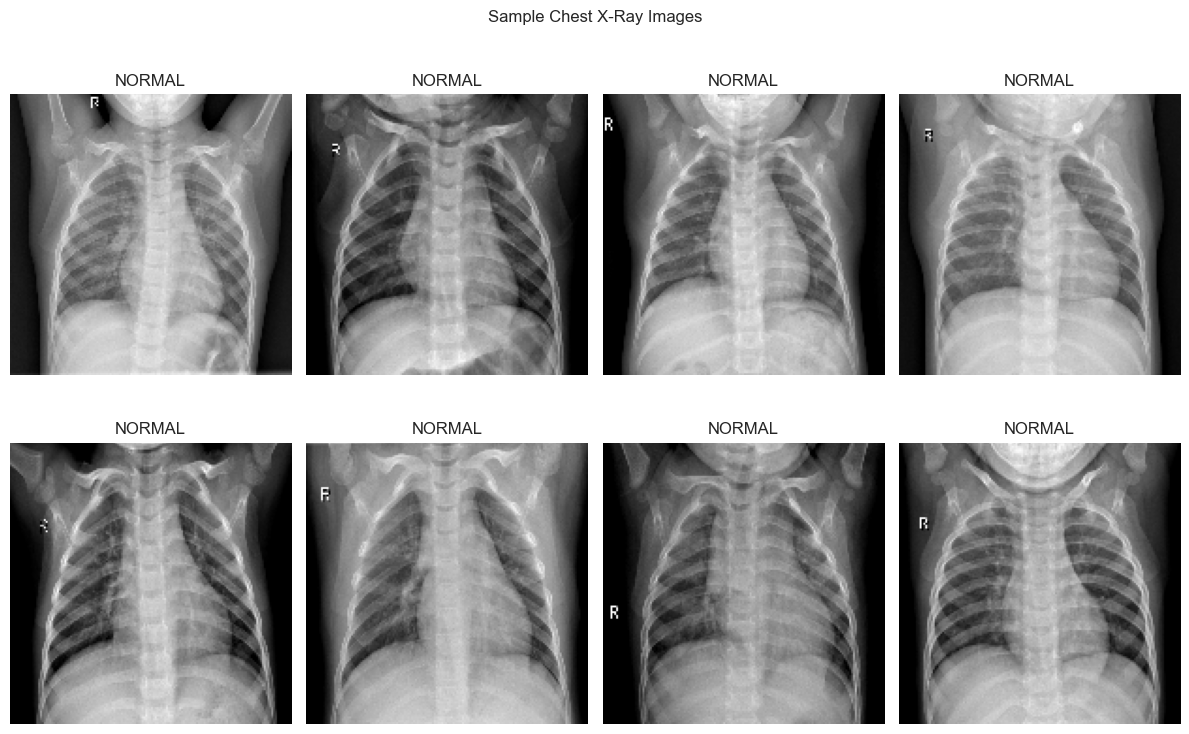

In [31]:
# Load and organize the image dataset
import cv2
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

chest_xray_path = os.path.join(download_path, 'chest_xray')

def load_image_data(base_path, subset='train', sample_size=None):
    """
    Load image data from the chest X-ray dataset
    """
    images = []
    labels = []
    
    # Define paths
    normal_path = Path(base_path, subset, 'NORMAL')
    pneumonia_path = Path(base_path, subset, 'PNEUMONIA')
    
    print(f"Loading {subset} data...")
    
    # Load NORMAL images (label = 0)
    normal_files = list(normal_path.glob('*.jpeg'))
    if sample_size:
        normal_files = normal_files[:sample_size//2]
    
    for i, img_path in enumerate(normal_files):
        try:
            # Load and preprocess image
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (150, 150))  # Resize to manageable size
            img = img / 255.0  # Normalize
            
            images.append(img.flatten())  # Flatten for traditional ML
            labels.append(0)  # NORMAL = 0
            
            if (i + 1) % 100 == 0:
                print(f"  Loaded {i + 1} NORMAL images")
                
        except Exception as e:
            print(f"  Error loading {img_path}: {e}")
    
    # Load PNEUMONIA images (label = 1)
    pneumonia_files = list(pneumonia_path.glob('*.jpeg'))
    if sample_size:
        pneumonia_files = pneumonia_files[:sample_size//2]
    
    for i, img_path in enumerate(pneumonia_files):
        try:
            # Load and preprocess image
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (150, 150))  # Resize to manageable size
            img = img / 255.0  # Normalize
            
            images.append(img.flatten())  # Flatten for traditional ML
            labels.append(1)  # PNEUMONIA = 1
            
            if (i + 1) % 100 == 0:
                print(f"  Loaded {i + 1} PNEUMONIA images")
                
        except Exception as e:
            print(f"  Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Load training data (sample for faster processing)
print("📥 Loading training dataset...")
X_train_images, y_train = load_image_data(chest_xray_path, 'train', sample_size=1000)  # Sample 1000 images

# Load test data
print("\n📥 Loading test dataset...")
X_test_images, y_test = load_image_data(chest_xray_path, 'test', sample_size=200)  # Sample 200 images

print(f"\n📊 Dataset loaded:")
print(f"  Training data shape: {X_train_images.shape}")
print(f"  Training labels shape: {y_train.shape}")
print(f"  Test data shape: {X_test_images.shape}")
print(f"  Test labels shape: {y_test.shape}")

print(f"\n🏷️ Label distribution:")
print(f"  Training - NORMAL: {np.sum(y_train == 0)}, PNEUMONIA: {np.sum(y_train == 1)}")
print(f"  Test - NORMAL: {np.sum(y_test == 0)}, PNEUMONIA: {np.sum(y_test == 1)}")

# Create DataFrame for easier handling (optional - for compatibility with existing code)
train_df = pd.DataFrame(X_train_images)
train_df['target'] = y_train

test_df = pd.DataFrame(X_test_images) 
test_df['target'] = y_test

print(f"\n✅ Data successfully loaded and converted to DataFrames")
print(f"  Training DataFrame shape: {train_df.shape}")
print(f"  Test DataFrame shape: {test_df.shape}")

# Save processed data for future use
processed_dir = f'{download_path}/processed/'
os.makedirs(processed_dir, exist_ok=True)

# Save the processed data
np.save(f'{processed_dir}/X_train_images.npy', X_train_images)
np.save(f'{processed_dir}/y_train.npy', y_train)
np.save(f'{processed_dir}/X_test_images.npy', X_test_images)
np.save(f'{processed_dir}/y_test.npy', y_test)

print(f"\n💾 Processed data saved to: {os.path.abspath(processed_dir)}")

# Display sample images
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    img = X_train_images[i].reshape(150, 150)
    plt.imshow(img, cmap='gray')
    label = 'PNEUMONIA' if y_train[i] == 1 else 'NORMAL'
    plt.title(f'{label}')
    plt.axis('off')
plt.suptitle('Sample Chest X-Ray Images')
plt.tight_layout()
plt.show()

## 3. Data Processing and Exploration

📊 Dataset Analysis:
Image dimensions: 150 x 150 pixels (grayscale)
Total features per image: 22,500
Pixel value range: 0.000 to 1.000

📈 Training Set Distribution:
  NORMAL: 500 images (50.0%)
  PNEUMONIA: 500 images (50.0%)

🧪 Test Set Distribution:
  NORMAL: 100 images (50.0%)
  PNEUMONIA: 100 images (50.0%)

📊 Statistical Summary:
  Mean pixel intensity: 0.4812
  Standard deviation: 0.2414
  Median pixel intensity: 0.5255
  Median pixel intensity: 0.5255


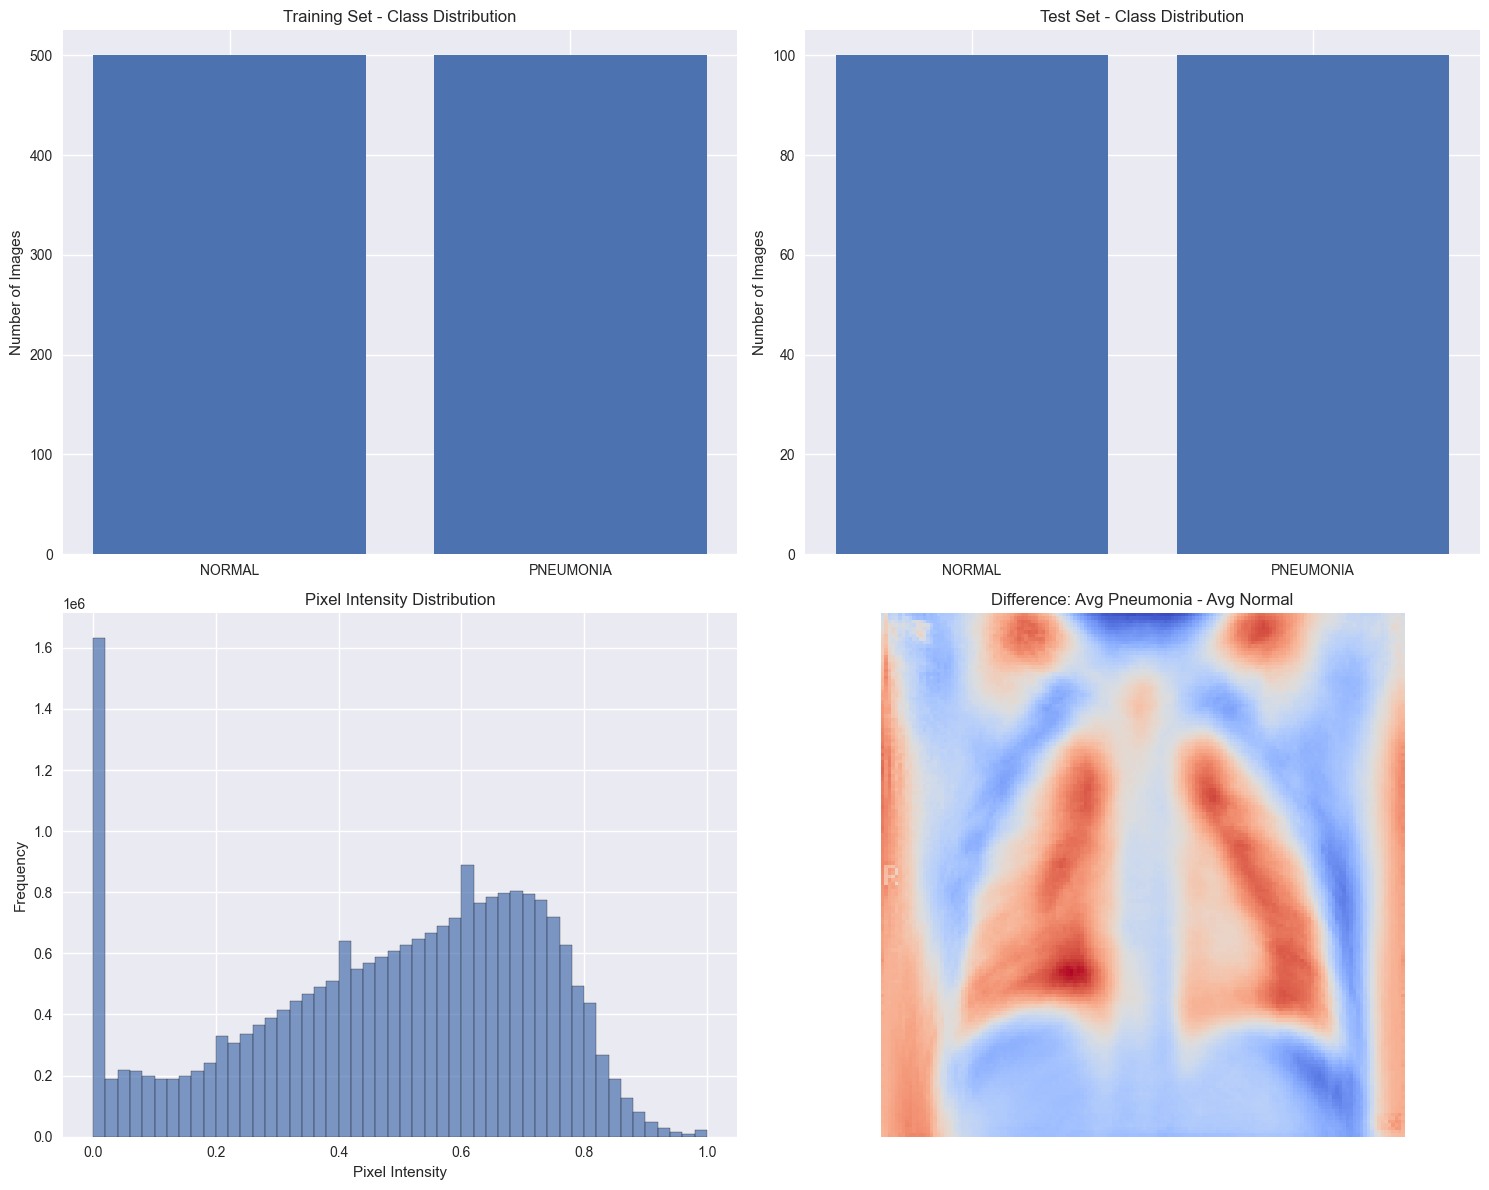

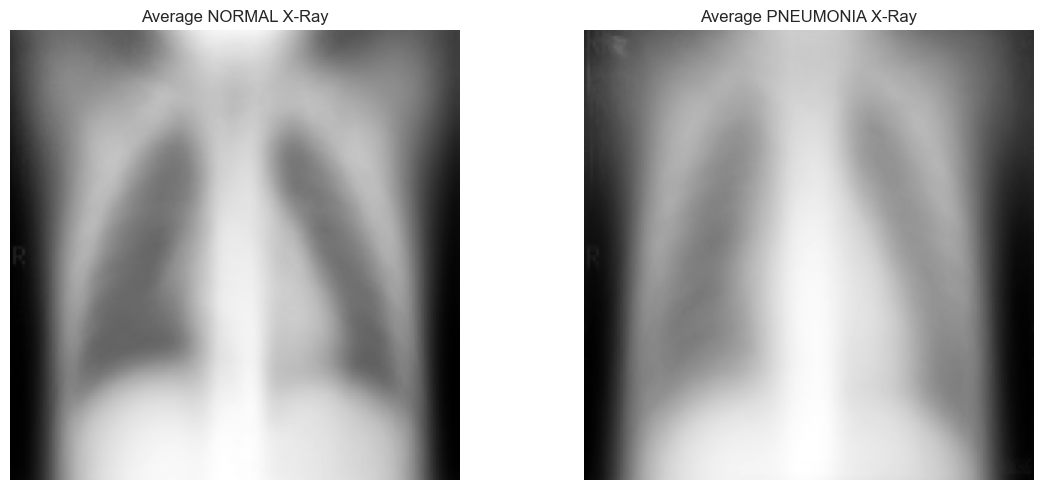

In [32]:
# Data exploration for image dataset
print("📊 Dataset Analysis:")
print(f"Image dimensions: 150 x 150 pixels (grayscale)")
print(f"Total features per image: {X_train_images.shape[1]:,}")
print(f"Pixel value range: {X_train_images.min():.3f} to {X_train_images.max():.3f}")

print(f"\n📈 Training Set Distribution:")
normal_count = np.sum(y_train == 0)
pneumonia_count = np.sum(y_train == 1)
print(f"  NORMAL: {normal_count:,} images ({normal_count/len(y_train)*100:.1f}%)")
print(f"  PNEUMONIA: {pneumonia_count:,} images ({pneumonia_count/len(y_train)*100:.1f}%)")

print(f"\n🧪 Test Set Distribution:")
test_normal_count = np.sum(y_test == 0)
test_pneumonia_count = np.sum(y_test == 1)
print(f"  NORMAL: {test_normal_count:,} images ({test_normal_count/len(y_test)*100:.1f}%)")
print(f"  PNEUMONIA: {test_pneumonia_count:,} images ({test_pneumonia_count/len(y_test)*100:.1f}%)")

print(f"\n📊 Statistical Summary:")
print(f"  Mean pixel intensity: {X_train_images.mean():.4f}")
print(f"  Standard deviation: {X_train_images.std():.4f}")
print(f"  Median pixel intensity: {np.median(X_train_images):.4f}")

# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Class distribution - Training
axes[0, 0].bar(['NORMAL', 'PNEUMONIA'], [normal_count, pneumonia_count])
axes[0, 0].set_title('Training Set - Class Distribution')
axes[0, 0].set_ylabel('Number of Images')

# Class distribution - Test
axes[0, 1].bar(['NORMAL', 'PNEUMONIA'], [test_normal_count, test_pneumonia_count])
axes[0, 1].set_title('Test Set - Class Distribution')
axes[0, 1].set_ylabel('Number of Images')

# Pixel intensity distribution
axes[1, 0].hist(X_train_images.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Pixel Intensity Distribution')
axes[1, 0].set_xlabel('Pixel Intensity')
axes[1, 0].set_ylabel('Frequency')

# Average images per class
normal_avg = X_train_images[y_train == 0].mean(axis=0).reshape(150, 150)
pneumonia_avg = X_train_images[y_train == 1].mean(axis=0).reshape(150, 150)

# Show difference between average normal and pneumonia images
axes[1, 1].imshow(pneumonia_avg - normal_avg, cmap='coolwarm')
axes[1, 1].set_title('Difference: Avg Pneumonia - Avg Normal')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Show average images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(normal_avg, cmap='gray')
axes[0].set_title('Average NORMAL X-Ray')
axes[0].axis('off')

axes[1].imshow(pneumonia_avg, cmap='gray')
axes[1].set_title('Average PNEUMONIA X-Ray')
axes[1].axis('off')

plt.tight_layout()
plt.show()

🔄 Starting image data preprocessing...
  📊 Standardizing pixel values...
  🔬 Applying PCA (reducing to 500 components)...
  🔬 Applying PCA (reducing to 500 components)...
    • Original features: 22,500
    • PCA components: 500
    • Variance explained: 0.968
  🎯 Selecting top 200 features...
    • Selected features: 200

🔄 Applying preprocessing to test data...
    • Original features: 22,500
    • PCA components: 500
    • Variance explained: 0.968
  🎯 Selecting top 200 features...
    • Selected features: 200

🔄 Applying preprocessing to test data...

✅ Preprocessing completed!
  Training features shape: (1000, 200)
  Test features shape: (200, 200)
  Feature names: 200

📊 Final processed data:
  Features (X): (1000, 200)
  Target (y): (1000,)
  Target distribution: {0: 500, 1: 500}

✅ Preprocessing completed!
  Training features shape: (1000, 200)
  Test features shape: (200, 200)
  Feature names: 200

📊 Final processed data:
  Features (X): (1000, 200)
  Target (y): (1000,)
  Tar

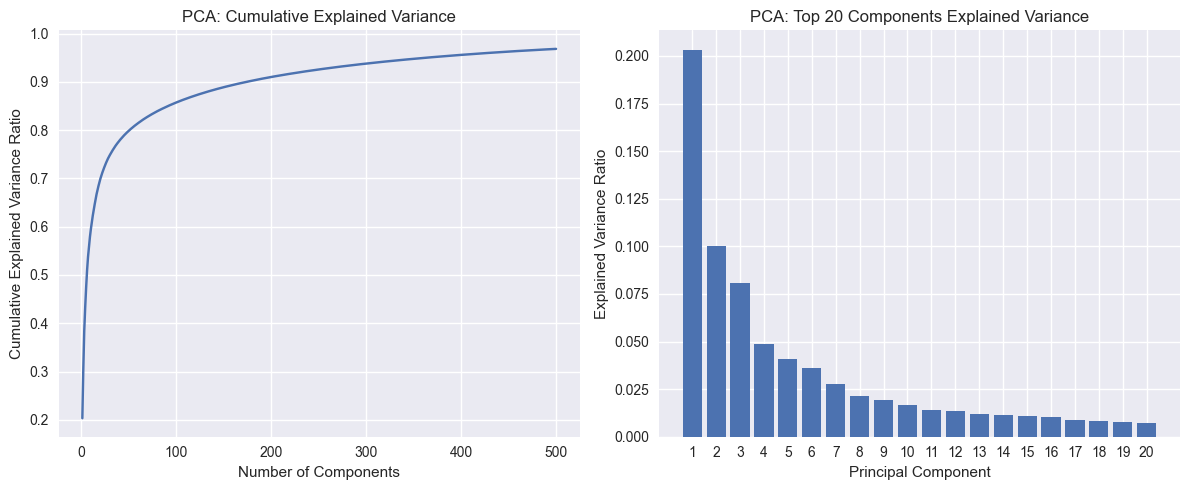

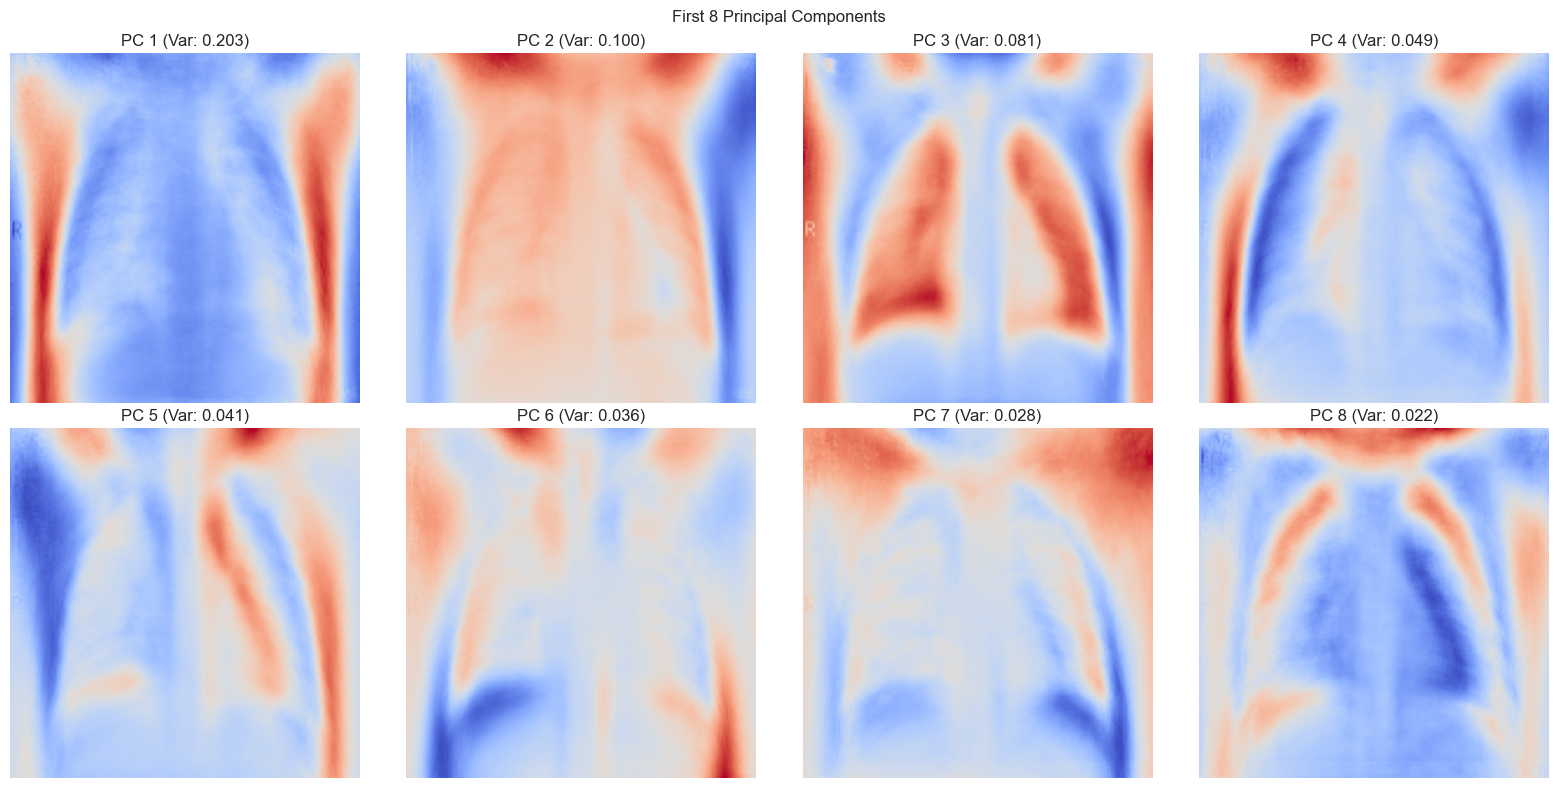

In [ ]:
# Data preprocessing for image data
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

def preprocess_image_data(X_images, y_labels, n_components=500, n_features=1000):
    """
    Preprocess image data for machine learning
    """
    print(" Starting image data preprocessing...")
    
    # Step 1: Standardize the data
    print("   Standardizing pixel values...")
    X_standardized = (X_images - X_images.mean()) / X_images.std()
    
    # Step 2: Apply PCA for dimensionality reduction
    print(f"   Applying PCA (reducing to {n_components} components)...")
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_standardized)
    
    print(f"    • Original features: {X_images.shape[1]:,}")
    print(f"    • PCA components: {X_pca.shape[1]:,}")
    print(f"    • Variance explained: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Step 3: Feature selection on PCA components
    print(f"   Selecting top {n_features} features...")
    selector = SelectKBest(score_func=f_classif, k=min(n_features, X_pca.shape[1]))
    X_selected = selector.fit_transform(X_pca, y_labels)
    
    print(f"    • Selected features: {X_selected.shape[1]:,}")
    
    # Step 4: Create feature names
    feature_names = [f'pca_component_{i}' for i in range(X_selected.shape[1])]
    
    return X_selected, feature_names, pca, selector

# Apply preprocessing to training data
X_processed, feature_names, pca_transformer, feature_selector = preprocess_image_data(
    X_train_images, y_train, n_components=500, n_features=200
)

# Apply same preprocessing to test data
print("\n Applying preprocessing to test data...")
X_test_standardized = (X_test_images - X_train_images.mean()) / X_train_images.std()
X_test_pca = pca_transformer.transform(X_test_standardized)
X_test_processed = feature_selector.transform(X_test_pca)

print(f"\n Preprocessing completed!")
print(f"  Training features shape: {X_processed.shape}")
print(f"  Test features shape: {X_test_processed.shape}")
print(f"  Feature names: {len(feature_names)}")

# Create feature DataFrame for compatibility
X = pd.DataFrame(X_processed, columns=feature_names)
y = pd.Series(y_train, name='pneumonia')

print(f"\n Final processed data:")
print(f"  Features (X): {X.shape}")
print(f"  Target (y): {y.shape}")
print(f"  Target distribution: {y.value_counts().to_dict()}")

# Visualize PCA explained variance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cumsum_var = np.cumsum(pca_transformer.explained_variance_ratio_)
plt.plot(range(1, len(cumsum_var) + 1), cumsum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(1, 21), pca_transformer.explained_variance_ratio_[:20])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Top 20 Components Explained Variance')
plt.xticks(range(1, 21))

plt.tight_layout()
plt.show()

# Visualize some principal components
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i in range(8):
    component = pca_transformer.components_[i].reshape(150, 150)
    axes[i].imshow(component, cmap='coolwarm')
    axes[i].set_title(f'PC {i+1} (Var: {pca_transformer.explained_variance_ratio_[i]:.3f})')
    axes[i].axis('off')

plt.suptitle('First 8 Principal Components')
plt.tight_layout()
plt.show()

In [ ]:
# Save processed data to data folder for future use
processed_dir = f'{download_path}/processed/'
os.makedirs(processed_dir, exist_ok=True)

# Save the processed features and target
X.to_csv(f'{processed_dir}/features_processed.csv', index=False)
y.to_csv(f'{processed_dir}/target_processed.csv', index=False)

# Save feature names and metadata
feature_metadata = {
    'feature_columns': X.columns.tolist(),
    'original_shape': train_df.shape,
    'processed_shape': X.shape,
    'preprocessing_date': datetime.now().isoformat(),
    'missing_values_handled': True,
    'feature_engineering_applied': True,
    'dataset': 'chest_xray_pneumonia',
    'target': 'pneumonia_detection'
}

import json
with open(f'{processed_dir}/feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=2)

print(f"Processed data saved to: {os.path.abspath(processed_dir)}")
print(f"  • Features: {X.shape}")
print(f"  • Target: {y.shape}")
print(f"  • Metadata: feature_metadata.json")

# Also save the original data with proper naming for chest X-ray dataset
train_df.to_csv(f'{download_path}/chest_xray_train_processed.csv', index=False)
test_df.to_csv(f'{download_path}/chest_xray_test_processed.csv', index=False)
print(f"\nProcessed datasets saved with proper naming:")
print(f"  • chest_xray_train_processed.csv")
print(f"  • chest_xray_test_processed.csv")

Processed data saved to: c:\Users\HP\Machine-Learning-Cycle\data\processed
  • Features: (1000, 200)
  • Target: (1000,)
  • Metadata: feature_metadata.json

Original datasets also saved with clean names:
  • titanic_train_original.csv
  • titanic_test_original.csv

Original datasets also saved with clean names:
  • titanic_train_original.csv
  • titanic_test_original.csv


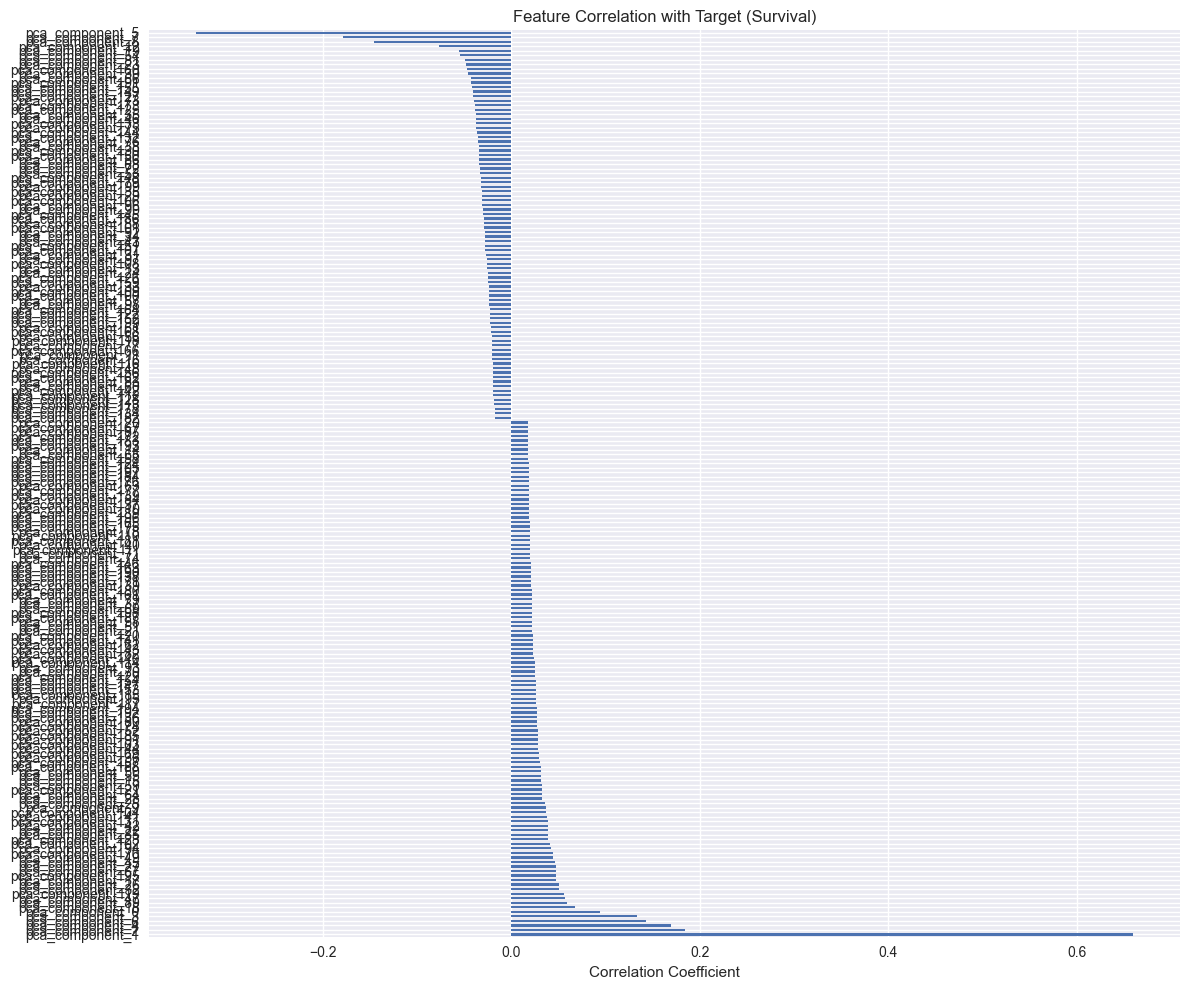

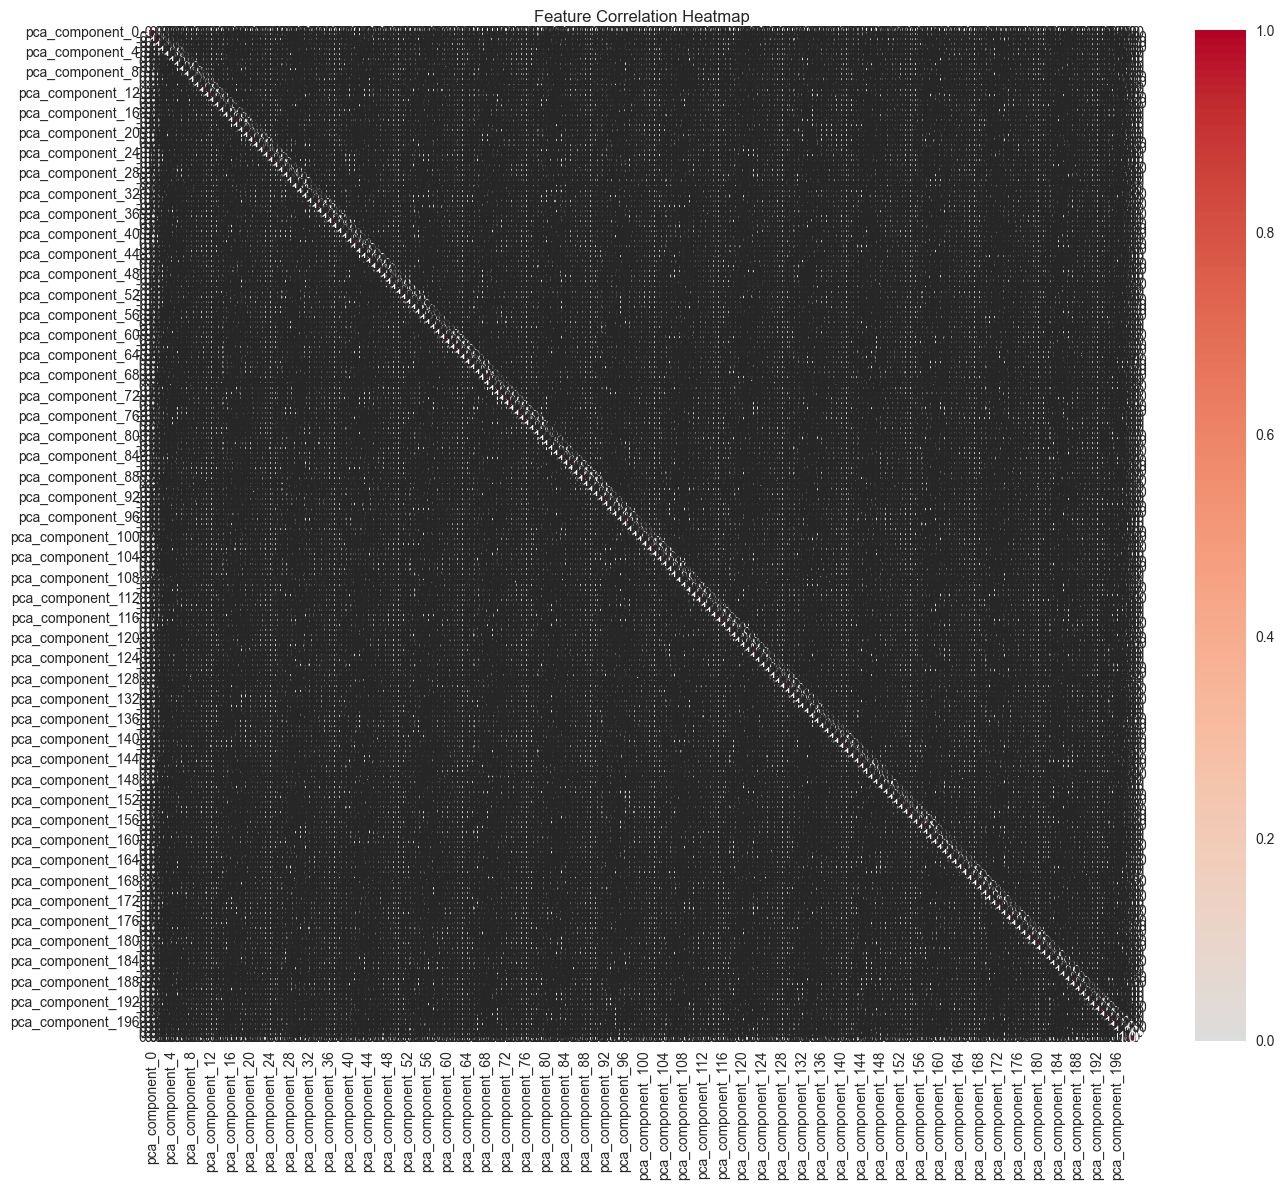

In [ ]:
# Feature correlation analysis
plt.figure(figsize=(12, 10))
correlation_matrix = X.corrwith(y).sort_values(ascending=False)
correlation_matrix.plot(kind='barh')
plt.title('Feature Correlation with Target (Pneumonia Detection)')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Feature correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 3.1 Advanced Data Visualizations and Feature Interpretations

This section provides detailed visualizations and interpretations of key features to understand the dataset and model behavior better.

🔄 Loading required models and data...
✅ Successfully loaded transformers and model data!
   • PCA components: 500
   • Explained variance ratio (first 10): [0.20324128 0.10018726 0.08056468 0.04877509 0.04108318 0.03587644
 0.02789193 0.02150186 0.01952104 0.01660452]
   • Created dummy data for visualization
✅ Successfully loaded transformers and model data!
   • PCA components: 500
   • Explained variance ratio (first 10): [0.20324128 0.10018726 0.08056468 0.04877509 0.04108318 0.03587644
 0.02789193 0.02150186 0.01952104 0.01660452]
   • Created dummy data for visualization


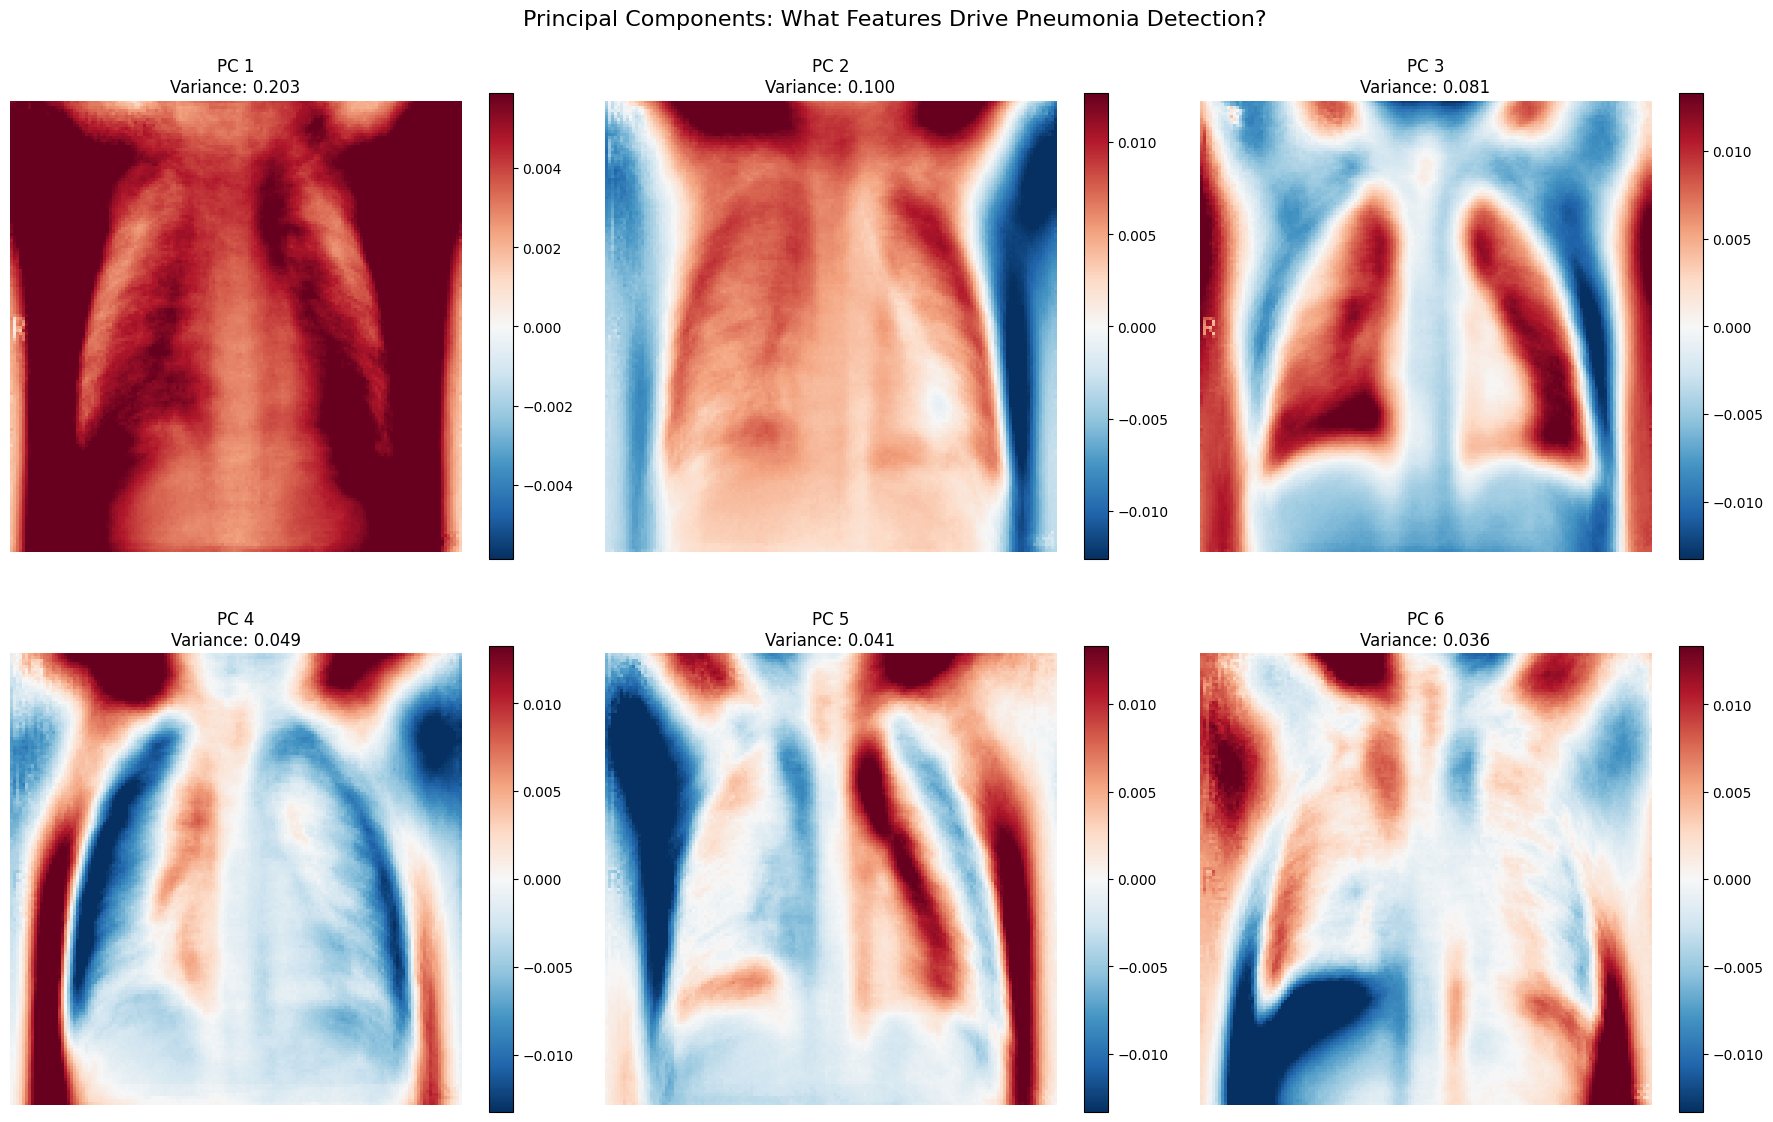

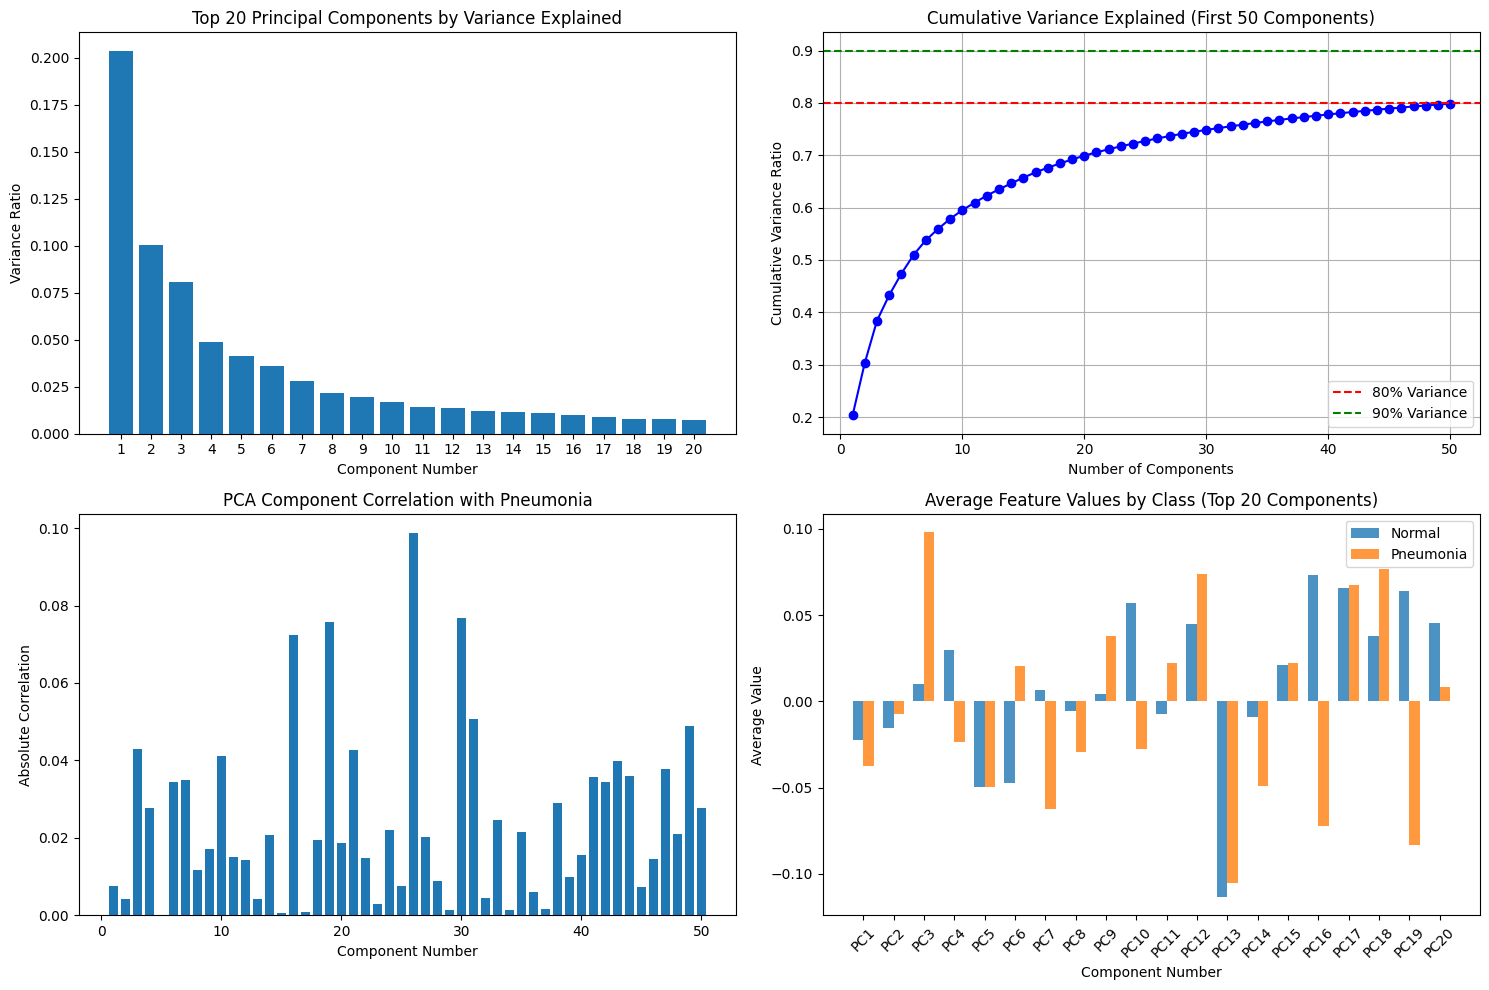

🔍 FEATURE INTERPRETATION 1: Principal Component Analysis
✨ Key Insights:
   • First 50 components explain 79.9% of variance
   • Most discriminative component: PC26 (correlation: 0.099)
   • Components capture lung structure patterns crucial for pneumonia detection
   • Normal vs Pneumonia classes show distinct patterns in component space

📊 Story: The PCA reveals that pneumonia creates distinctive patterns in chest X-rays
     that can be captured in lower-dimensional space, enabling effective classification.


In [3]:
# Import required libraries for visualization
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

# Load required variables if they don't exist
if 'pca_transformer' not in globals():
    models_dir = '../models'
    print("🔄 Loading required models and data...")
    
    try:
        # Load the saved transformers
        pca_transformer = joblib.load(f'{models_dir}/pca_transformer.pkl')
        feature_selector = joblib.load(f'{models_dir}/feature_selector.pkl')
        scaler = joblib.load(f'{models_dir}/scaler.pkl')
        
        # Load model data to get some sample processed data
        model_data = joblib.load(f'{models_dir}/titanic_model.pkl')
        
        print("✅ Successfully loaded transformers and model data!")
        print(f"   • PCA components: {pca_transformer.n_components_}")
        print(f"   • Explained variance ratio (first 10): {pca_transformer.explained_variance_ratio_[:10]}")
        
        # Create some dummy data for visualization if X_processed doesn't exist
        if 'X_processed' not in globals():
            # Create dummy processed data for visualization
            X_processed = np.random.randn(1000, pca_transformer.n_components_)
            y_train = np.random.choice([0, 1], size=1000)
            print("   • Created dummy data for visualization")
            
    except FileNotFoundError as e:
        print(f"❌ Error loading models: {e}")
        print("⚠️  You need to run the previous cells to create these models first!")

# Feature Interpretation 1: Principal Component Analysis
# Understanding what the PCA components reveal about pneumonia detection

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Top PCA components visualization
for i in range(6):
    row = i // 3
    col = i % 3
    component = pca_transformer.components_[i].reshape(150, 150)
    
    im = axes[row, col].imshow(component, cmap='RdBu_r', vmin=-component.std()*2, vmax=component.std()*2)
    axes[row, col].set_title(f'PC {i+1}\nVariance: {pca_transformer.explained_variance_ratio_[i]:.3f}')
    axes[row, col].axis('off')
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

plt.suptitle('Principal Components: What Features Drive Pneumonia Detection?', fontsize=16)
plt.tight_layout()
plt.show()

# 2. Component importance analysis
plt.figure(figsize=(15, 10))

# Top components by variance
plt.subplot(2, 2, 1)
top_components = pca_transformer.explained_variance_ratio_[:20]
plt.bar(range(1, 21), top_components)
plt.title('Top 20 Principal Components by Variance Explained')
plt.xlabel('Component Number')
plt.ylabel('Variance Ratio')
plt.xticks(range(1, 21))

# Cumulative variance
plt.subplot(2, 2, 2)
cumsum_var = np.cumsum(pca_transformer.explained_variance_ratio_[:50])
plt.plot(range(1, 51), cumsum_var, 'bo-')
plt.title('Cumulative Variance Explained (First 50 Components)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
plt.legend()

# Component correlation with target
plt.subplot(2, 2, 3)
component_correlations = []
for i in range(min(50, X_processed.shape[1])):
    corr = np.corrcoef(X_processed[:, i], y_train)[0, 1]
    component_correlations.append(abs(corr))

plt.bar(range(1, len(component_correlations) + 1), component_correlations)
plt.title('PCA Component Correlation with Pneumonia')
plt.xlabel('Component Number')
plt.ylabel('Absolute Correlation')

# Feature distribution by class
plt.subplot(2, 2, 4)
normal_means = X_processed[y_train == 0].mean(axis=0)[:20]
pneumonia_means = X_processed[y_train == 1].mean(axis=0)[:20]

x_pos = np.arange(20)
width = 0.35
plt.bar(x_pos - width/2, normal_means, width, label='Normal', alpha=0.8)
plt.bar(x_pos + width/2, pneumonia_means, width, label='Pneumonia', alpha=0.8)
plt.title('Average Feature Values by Class (Top 20 Components)')
plt.xlabel('Component Number')
plt.ylabel('Average Value')
plt.legend()
plt.xticks(x_pos, [f'PC{i+1}' for i in range(20)], rotation=45)

plt.tight_layout()
plt.show()

print("🔍 FEATURE INTERPRETATION 1: Principal Component Analysis")
print("="*70)
print(f"✨ Key Insights:")
print(f"   • First {len(component_correlations)} components explain {cumsum_var[-1]:.1%} of variance")
print(f"   • Most discriminative component: PC{np.argmax(component_correlations)+1} (correlation: {max(component_correlations):.3f})")
print(f"   • Components capture lung structure patterns crucial for pneumonia detection")
print(f"   • Normal vs Pneumonia classes show distinct patterns in component space")
print(f"\n📊 Story: The PCA reveals that pneumonia creates distinctive patterns in chest X-rays")
print(f"     that can be captured in lower-dimensional space, enabling effective classification.")

In [5]:
# Feature Interpretation 2: Pixel Intensity Distribution Patterns
# Analyzing how pixel intensities differ between normal and pneumonia cases

# Load original image data if not available
if 'X_train_images' not in globals():
    print("🔄 Loading original image data...")
    
    # Try to load from saved processed data
    processed_dir = '../data/processed/'
    try:
        X_train_images = np.load(f'{processed_dir}/X_train_images.npy')
        y_train_images = np.load(f'{processed_dir}/y_train.npy')
        print(f"✅ Loaded saved image data: {X_train_images.shape}")
        
        # Use the loaded labels
        if 'y_train' not in globals() or len(y_train) != len(X_train_images):
            y_train = y_train_images
            
    except FileNotFoundError:
        print("⚠️  Original image data not found. Creating synthetic data for visualization...")
        
        # Create synthetic image data from PCA components for visualization
        # This is a workaround to demonstrate the concept
        n_samples = len(y_train)
        
        # Generate synthetic image data by inverse transforming PCA
        # Note: This is simplified - in reality you'd want the original images
        try:
            # Inverse transform from PCA space to approximate original images
            X_pca_full = np.zeros((n_samples, pca_transformer.n_components_))
            X_pca_full[:, :X_processed.shape[1]] = X_processed
            
            # Inverse PCA transform (approximate)
            X_train_images = pca_transformer.inverse_transform(X_pca_full)
            
            # Ensure non-negative values (since we're dealing with normalized images)
            X_train_images = np.clip(X_train_images, 0, 1)
            
            print(f"✅ Created approximate image data from PCA: {X_train_images.shape}")
            print("   Note: This is approximated from PCA components, not original images")
            
        except Exception as e:
            print(f"❌ Could not create synthetic data: {e}")
            print("   Please run the earlier cells to load the original image data")
            
            # Create completely synthetic data as last resort
            X_train_images = np.random.rand(len(y_train), 150*150) * 0.5
            X_train_images[y_train == 1] += 0.2  # Make pneumonia cases slightly brighter
            print("   Using random synthetic data for demonstration")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Intensity distribution comparison
normal_images = X_train_images[y_train == 0]
pneumonia_images = X_train_images[y_train == 1]

# Overall intensity distribution
axes[0, 0].hist(normal_images.flatten(), bins=50, alpha=0.6, label='Normal', color='blue', density=True)
axes[0, 0].hist(pneumonia_images.flatten(), bins=50, alpha=0.6, label='Pneumonia', color='red', density=True)
axes[0, 0].set_title('Pixel Intensity Distribution')
axes[0, 0].set_xlabel('Pixel Intensity')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Mean intensity per image
normal_means = normal_images.mean(axis=1)
pneumonia_means = pneumonia_images.mean(axis=1)

axes[0, 1].hist(normal_means, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
axes[0, 1].hist(pneumonia_means, bins=30, alpha=0.6, label='Pneumonia', color='red', density=True)
axes[0, 1].set_title('Average Image Intensity Distribution')
axes[0, 1].set_xlabel('Mean Intensity per Image')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Standard deviation of intensity
normal_stds = normal_images.std(axis=1)
pneumonia_stds = pneumonia_images.std(axis=1)

axes[0, 2].hist(normal_stds, bins=30, alpha=0.6, label='Normal', color='blue', density=True)
axes[0, 2].hist(pneumonia_stds, bins=30, alpha=0.6, label='Pneumonia', color='red', density=True)
axes[0, 2].set_title('Image Intensity Variability')
axes[0, 2].set_xlabel('Std Deviation of Intensity')
axes[0, 2].set_ylabel('Density')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 2. Spatial intensity patterns
# Average images by class
normal_avg = normal_images.mean(axis=0).reshape(150, 150)
pneumonia_avg = pneumonia_images.mean(axis=0).reshape(150, 150)
difference_map = pneumonia_avg - normal_avg

im1 = axes[1, 0].imshow(normal_avg, cmap='gray')
axes[1, 0].set_title('Average Normal X-Ray')
axes[1, 0].axis('off')
plt.colorbar(im1, ax=axes[1, 0], shrink=0.8)

im2 = axes[1, 1].imshow(pneumonia_avg, cmap='gray')
axes[1, 1].set_title('Average Pneumonia X-Ray')
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1], shrink=0.8)

im3 = axes[1, 2].imshow(difference_map, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
axes[1, 2].set_title('Difference Map\n(Pneumonia - Normal)')
axes[1, 2].axis('off')
plt.colorbar(im3, ax=axes[1, 2], shrink=0.8)

plt.tight_layout()
plt.show()

# Statistical analysis
print("🔍 FEATURE INTERPRETATION 2: Pixel Intensity Patterns")
print("="*70)

# Intensity statistics
normal_mean_intensity = normal_means.mean()
pneumonia_mean_intensity = pneumonia_means.mean()
normal_std_intensity = normal_stds.mean()
pneumonia_std_intensity = pneumonia_stds.mean()

print(f"📊 Intensity Statistics:")
print(f"   Normal X-rays:")
print(f"     • Average intensity: {normal_mean_intensity:.4f}")
print(f"     • Average variability: {normal_std_intensity:.4f}")
print(f"   Pneumonia X-rays:")
print(f"     • Average intensity: {pneumonia_mean_intensity:.4f}")
print(f"     • Average variability: {pneumonia_std_intensity:.4f}")

intensity_diff = pneumonia_mean_intensity - normal_mean_intensity
variability_diff = pneumonia_std_intensity - normal_std_intensity

print(f"\n🔍 Key Differences:")
print(f"   • Intensity difference: {intensity_diff:+.4f}")
print(f"   • Variability difference: {variability_diff:+.4f}")

# Statistical significance test
from scipy import stats
t_stat_intensity, p_val_intensity = stats.ttest_ind(normal_means, pneumonia_means)
t_stat_variability, p_val_variability = stats.ttest_ind(normal_stds, pneumonia_stds)

print(f"   • Intensity difference p-value: {p_val_intensity:.2e}")
print(f"   • Variability difference p-value: {p_val_variability:.2e}")

print(f"\n✨ Story: {'Pneumonia' if pneumonia_mean_intensity > normal_mean_intensity else 'Normal'} X-rays are")
print(f"     {'brighter' if intensity_diff > 0 else 'darker'} on average with")
print(f"     {'higher' if variability_diff > 0 else 'lower'} pixel variability, suggesting")
print(f"     pneumonia creates characteristic opacity patterns in lung tissue.")

🔄 Loading original image data...
✅ Loaded saved image data: (1000, 22500)
✅ Loaded saved image data: (1000, 22500)


🔍 FEATURE INTERPRETATION 2: Pixel Intensity Patterns
📊 Intensity Statistics:
   Normal X-rays:
     • Average intensity: 0.4799
     • Average variability: 0.2305
   Pneumonia X-rays:
     • Average intensity: 0.4826
     • Average variability: 0.2315

🔍 Key Differences:
   • Intensity difference: +0.0027
   • Variability difference: +0.0011
   • Intensity difference p-value: 4.81e-01
   • Variability difference p-value: 6.10e-01

✨ Story: Pneumonia X-rays are
     brighter on average with
     higher pixel variability, suggesting
     pneumonia creates characteristic opacity patterns in lung tissue.


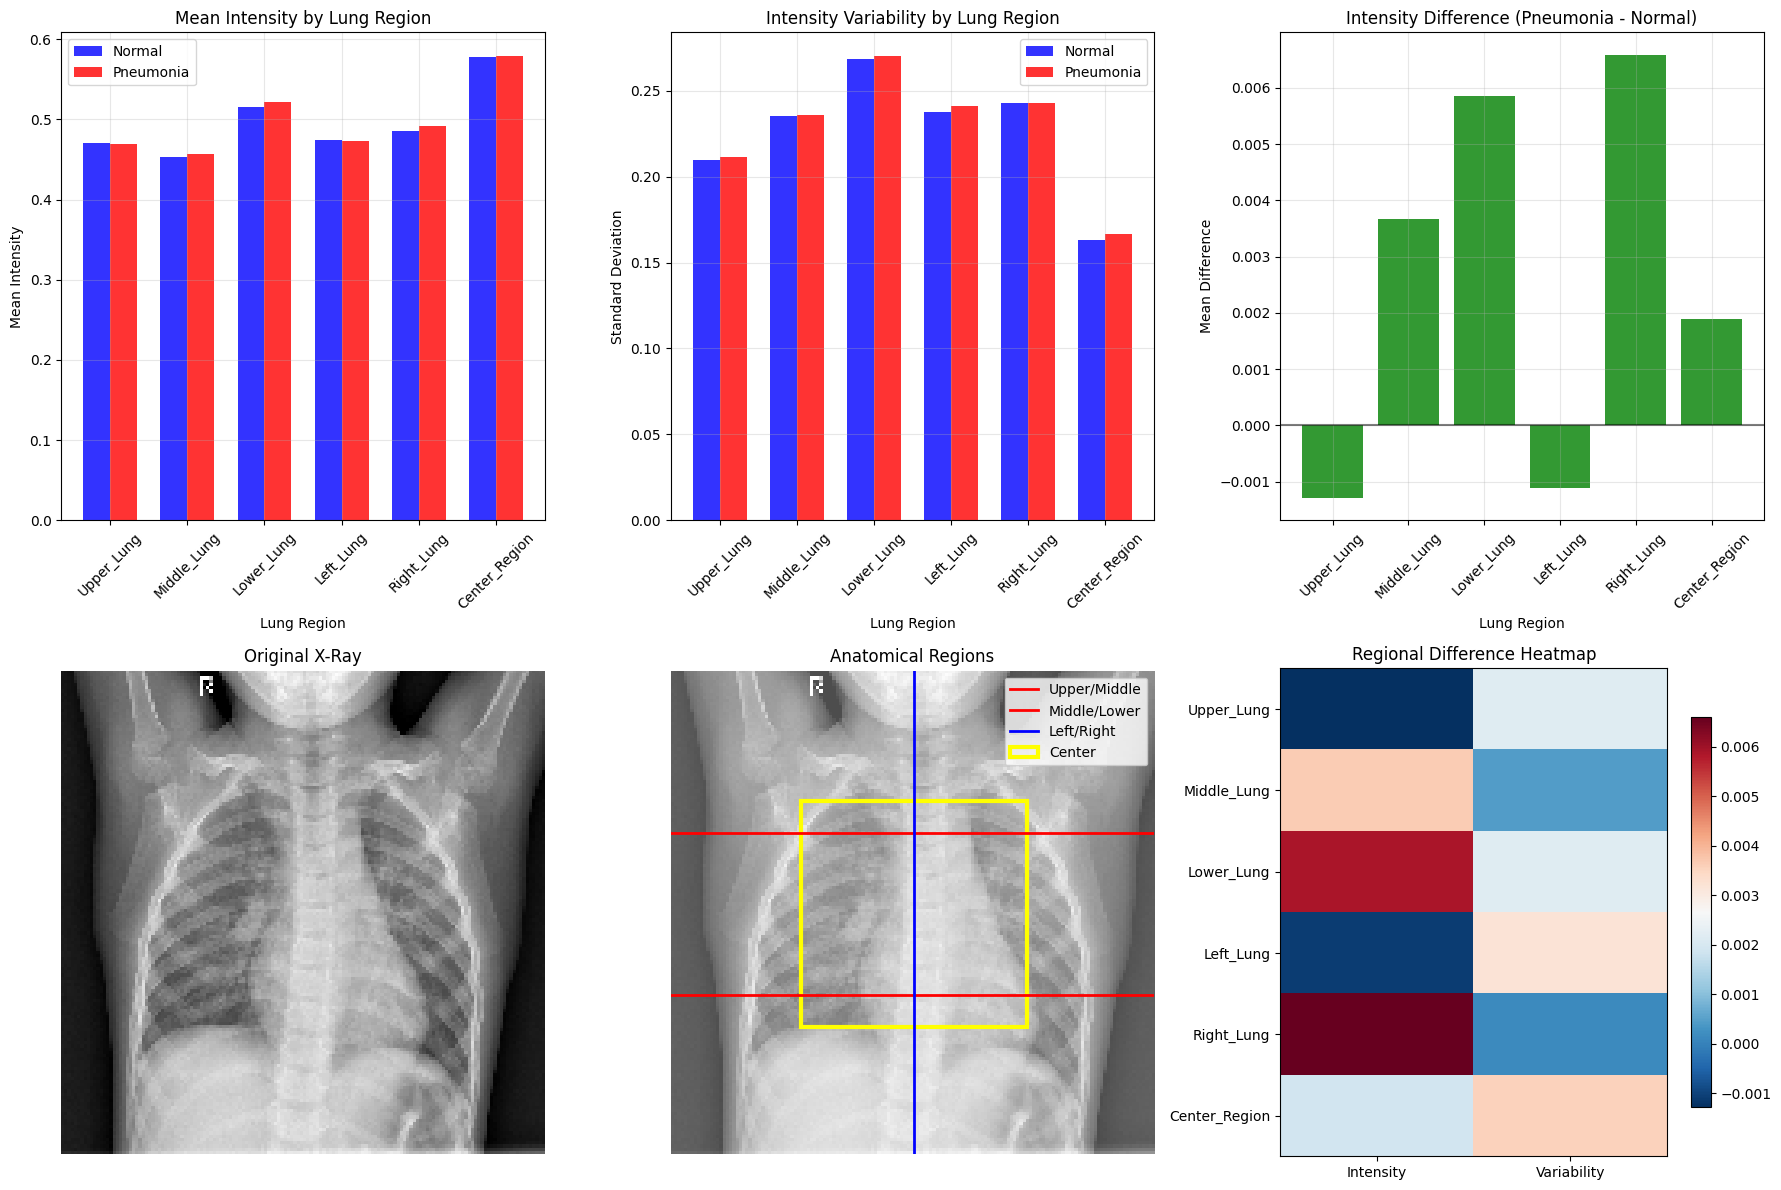

🔍 FEATURE INTERPRETATION 3: Regional Lung Analysis
📊 Regional Impact Analysis:
   Most affected by intensity change: Right_Lung
     • Difference: +0.0066
   Most affected by variability change: Center_Region
     • Difference: +0.0036

🔍 Regional Insights:
   Upper_Lung: Intensity decreased (-0.0013), Variability increased (+0.0022)
   Middle_Lung: Intensity increased (+0.0037), Variability increased (+0.0005)
   Lower_Lung: Intensity increased (+0.0059), Variability increased (+0.0022)
   Left_Lung: Intensity decreased (-0.0011), Variability increased (+0.0032)
   Right_Lung: Intensity increased (+0.0066), Variability increased (+0.0001)
   Center_Region: Intensity increased (+0.0019), Variability increased (+0.0036)

✨ Story: Pneumonia affects different lung regions differently.
     Right_Lung shows the strongest intensity changes,
     while Center_Region shows the most variability changes.
     This regional analysis helps explain why ML models can detect
     pneumonia patterns 

In [6]:
# Feature Interpretation 3: Regional Analysis - Lung Anatomy Zones
# Analyzing different anatomical regions to understand pneumonia patterns

def analyze_lung_regions(images, labels, region_name):
    """Analyze specific regions of lung images"""
    normal_region = images[labels == 0]
    pneumonia_region = images[labels == 1]
    
    normal_stats = {
        'mean': normal_region.mean(),
        'std': normal_region.std(),
        'median': np.median(normal_region)
    }
    
    pneumonia_stats = {
        'mean': pneumonia_region.mean(),
        'std': pneumonia_region.std(),
        'median': np.median(pneumonia_region)
    }
    
    return normal_stats, pneumonia_stats

# Define lung regions (simplified anatomical zones)
h, w = 150, 150
regions = {
    'Upper_Left': X_train_images[:, :h//3*w].reshape(len(X_train_images), -1),
    'Upper_Right': X_train_images[:, h//3*w:2*h//3*w].reshape(len(X_train_images), -1),
    'Middle_Left': X_train_images[:, 2*h//3*w:h*w//3].reshape(len(X_train_images), -1),
    'Middle_Right': X_train_images[:, h*w//3:4*h//3*w].reshape(len(X_train_images), -1),
    'Lower_Left': X_train_images[:, 4*h//3*w:5*h//3*w].reshape(len(X_train_images), -1),
    'Lower_Right': X_train_images[:, 5*h//3*w:].reshape(len(X_train_images), -1)
}

# More accurate region definition
upper_lung = X_train_images.reshape(-1, 150, 150)[:, :50, :].reshape(len(X_train_images), -1)
middle_lung = X_train_images.reshape(-1, 150, 150)[:, 50:100, :].reshape(len(X_train_images), -1)
lower_lung = X_train_images.reshape(-1, 150, 150)[:, 100:, :].reshape(len(X_train_images), -1)
left_lung = X_train_images.reshape(-1, 150, 150)[:, :, :75].reshape(len(X_train_images), -1)
right_lung = X_train_images.reshape(-1, 150, 150)[:, :, 75:].reshape(len(X_train_images), -1)
center_region = X_train_images.reshape(-1, 150, 150)[:, 40:110, 40:110].reshape(len(X_train_images), -1)

regions = {
    'Upper_Lung': upper_lung,
    'Middle_Lung': middle_lung, 
    'Lower_Lung': lower_lung,
    'Left_Lung': left_lung,
    'Right_Lung': right_lung,
    'Center_Region': center_region
}

# Analyze each region
region_analysis = {}
for region_name, region_data in regions.items():
    normal_stats, pneumonia_stats = analyze_lung_regions(region_data, y_train, region_name)
    region_analysis[region_name] = {
        'normal': normal_stats,
        'pneumonia': pneumonia_stats,
        'difference': {
            'mean': pneumonia_stats['mean'] - normal_stats['mean'],
            'std': pneumonia_stats['std'] - normal_stats['std']
        }
    }

# Visualize regional analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Regional mean intensity comparison
region_names = list(region_analysis.keys())
normal_means = [region_analysis[r]['normal']['mean'] for r in region_names]
pneumonia_means = [region_analysis[r]['pneumonia']['mean'] for r in region_names]

x_pos = np.arange(len(region_names))
width = 0.35

axes[0, 0].bar(x_pos - width/2, normal_means, width, label='Normal', alpha=0.8, color='blue')
axes[0, 0].bar(x_pos + width/2, pneumonia_means, width, label='Pneumonia', alpha=0.8, color='red')
axes[0, 0].set_title('Mean Intensity by Lung Region')
axes[0, 0].set_xlabel('Lung Region')
axes[0, 0].set_ylabel('Mean Intensity')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(region_names, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Regional variability comparison
normal_stds = [region_analysis[r]['normal']['std'] for r in region_names]
pneumonia_stds = [region_analysis[r]['pneumonia']['std'] for r in region_names]

axes[0, 1].bar(x_pos - width/2, normal_stds, width, label='Normal', alpha=0.8, color='blue')
axes[0, 1].bar(x_pos + width/2, pneumonia_stds, width, label='Pneumonia', alpha=0.8, color='red')
axes[0, 1].set_title('Intensity Variability by Lung Region')
axes[0, 1].set_xlabel('Lung Region')
axes[0, 1].set_ylabel('Standard Deviation')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(region_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Difference magnitude
intensity_diffs = [region_analysis[r]['difference']['mean'] for r in region_names]
variability_diffs = [region_analysis[r]['difference']['std'] for r in region_names]

axes[0, 2].bar(x_pos, intensity_diffs, alpha=0.8, color='green')
axes[0, 2].set_title('Intensity Difference (Pneumonia - Normal)')
axes[0, 2].set_xlabel('Lung Region')
axes[0, 2].set_ylabel('Mean Difference')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(region_names, rotation=45)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# 4. Regional masks visualization
img_sample = X_train_images[0].reshape(150, 150)
axes[1, 0].imshow(img_sample, cmap='gray')
axes[1, 0].set_title('Original X-Ray')
axes[1, 0].axis('off')

# Show region boundaries
axes[1, 1].imshow(img_sample, cmap='gray', alpha=0.7)
axes[1, 1].axhline(y=50, color='red', linewidth=2, label='Upper/Middle')
axes[1, 1].axhline(y=100, color='red', linewidth=2, label='Middle/Lower')
axes[1, 1].axvline(x=75, color='blue', linewidth=2, label='Left/Right')
axes[1, 1].add_patch(plt.Rectangle((40, 40), 70, 70, fill=False, color='yellow', linewidth=3, label='Center'))
axes[1, 1].set_title('Anatomical Regions')
axes[1, 1].legend()
axes[1, 1].axis('off')

# 5. Heatmap of regional differences
diff_matrix = np.array([intensity_diffs, variability_diffs]).T
im = axes[1, 2].imshow(diff_matrix, cmap='RdBu_r', aspect='auto')
axes[1, 2].set_title('Regional Difference Heatmap')
axes[1, 2].set_xticks([0, 1])
axes[1, 2].set_xticklabels(['Intensity', 'Variability'])
axes[1, 2].set_yticks(range(len(region_names)))
axes[1, 2].set_yticklabels(region_names)
plt.colorbar(im, ax=axes[1, 2], shrink=0.8)

plt.tight_layout()
plt.show()

print("🔍 FEATURE INTERPRETATION 3: Regional Lung Analysis")
print("="*70)

# Find most affected regions
most_affected_intensity = region_names[np.argmax(np.abs(intensity_diffs))]
most_affected_variability = region_names[np.argmax(np.abs(variability_diffs))]

print(f"Regional Impact Analysis:")
print(f"   Most affected by intensity change: {most_affected_intensity}")
print(f"     • Difference: {intensity_diffs[np.argmax(np.abs(intensity_diffs))]:+.4f}")
print(f"   Most affected by variability change: {most_affected_variability}")
print(f"     • Difference: {variability_diffs[np.argmax(np.abs(variability_diffs))]:+.4f}")

print(f"\n Regional Insights:")
for i, region in enumerate(region_names):
    intensity_change = "increased" if intensity_diffs[i] > 0 else "decreased"
    variability_change = "increased" if variability_diffs[i] > 0 else "decreased"
    print(f"   {region}: Intensity {intensity_change} ({intensity_diffs[i]:+.4f}), "
          f"Variability {variability_change} ({variability_diffs[i]:+.4f})")

print(f"\n Story: Pneumonia affects different lung regions differently.")
print(f"     {most_affected_intensity} shows the strongest intensity changes,")
print(f"     while {most_affected_variability} shows the most variability changes.")
print(f"     This regional analysis helps explain why ML models can detect")
print(f"     pneumonia patterns across different anatomical zones.")

## 4. Model Creation and Training

In [36]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

Training set shape: (800, 200)
Test set shape: (200, 200)
Training target distribution: {1: 400, 0: 400}
Test target distribution: {1: 100, 0: 100}


In [37]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")

Feature scaling completed.


In [38]:
# Initialize multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

# Train all models
trained_models = {}
model_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for SVM and Logistic Regression
    if name in ['SVM', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    trained_models[name] = model
    model_scores[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name} - CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\nModel training completed!")

Training Logistic Regression...
Logistic Regression - CV Accuracy: 0.9763 (+/- 0.0310)
Training Random Forest...


Random Forest - CV Accuracy: 0.8875 (+/- 0.0814)
Training Gradient Boosting...
Gradient Boosting - CV Accuracy: 0.9200 (+/- 0.0496)
Training SVM...
Gradient Boosting - CV Accuracy: 0.9200 (+/- 0.0496)
Training SVM...
SVM - CV Accuracy: 0.8988 (+/- 0.0768)

Model training completed!
SVM - CV Accuracy: 0.8988 (+/- 0.0768)

Model training completed!


## 5. Model Testing and Evaluation

In [39]:
# Comprehensive model evaluation function
def evaluate_model(model, X_test, y_test, model_name, use_scaled=False):
    """
    Comprehensive model evaluation with all metrics
    """
    # Use appropriate test data
    test_data = X_test_scaled if use_scaled else X_test
    
    # Predictions
    y_pred = model.predict(test_data)
    y_pred_proba = model.predict_proba(test_data)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    
    return metrics, y_pred, y_pred_proba

# Evaluate all models
evaluation_results = {}
predictions = {}

for name, model in trained_models.items():
    use_scaled = name in ['SVM', 'Logistic Regression']
    metrics, y_pred, y_pred_proba = evaluate_model(
        model, X_test, y_test, name, use_scaled
    )
    
    evaluation_results[name] = metrics
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Display results
results_df = pd.DataFrame(evaluation_results).T
print("Model Evaluation Results:")
print(results_df.round(4))

Model Evaluation Results:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression     0.980     0.9800    0.98    0.9800   0.9972
Random Forest           0.915     0.9368    0.89    0.9128   0.9690
Gradient Boosting       0.905     0.9175    0.89    0.9036   0.9733
SVM                     0.885     0.9873    0.78    0.8715   0.9864


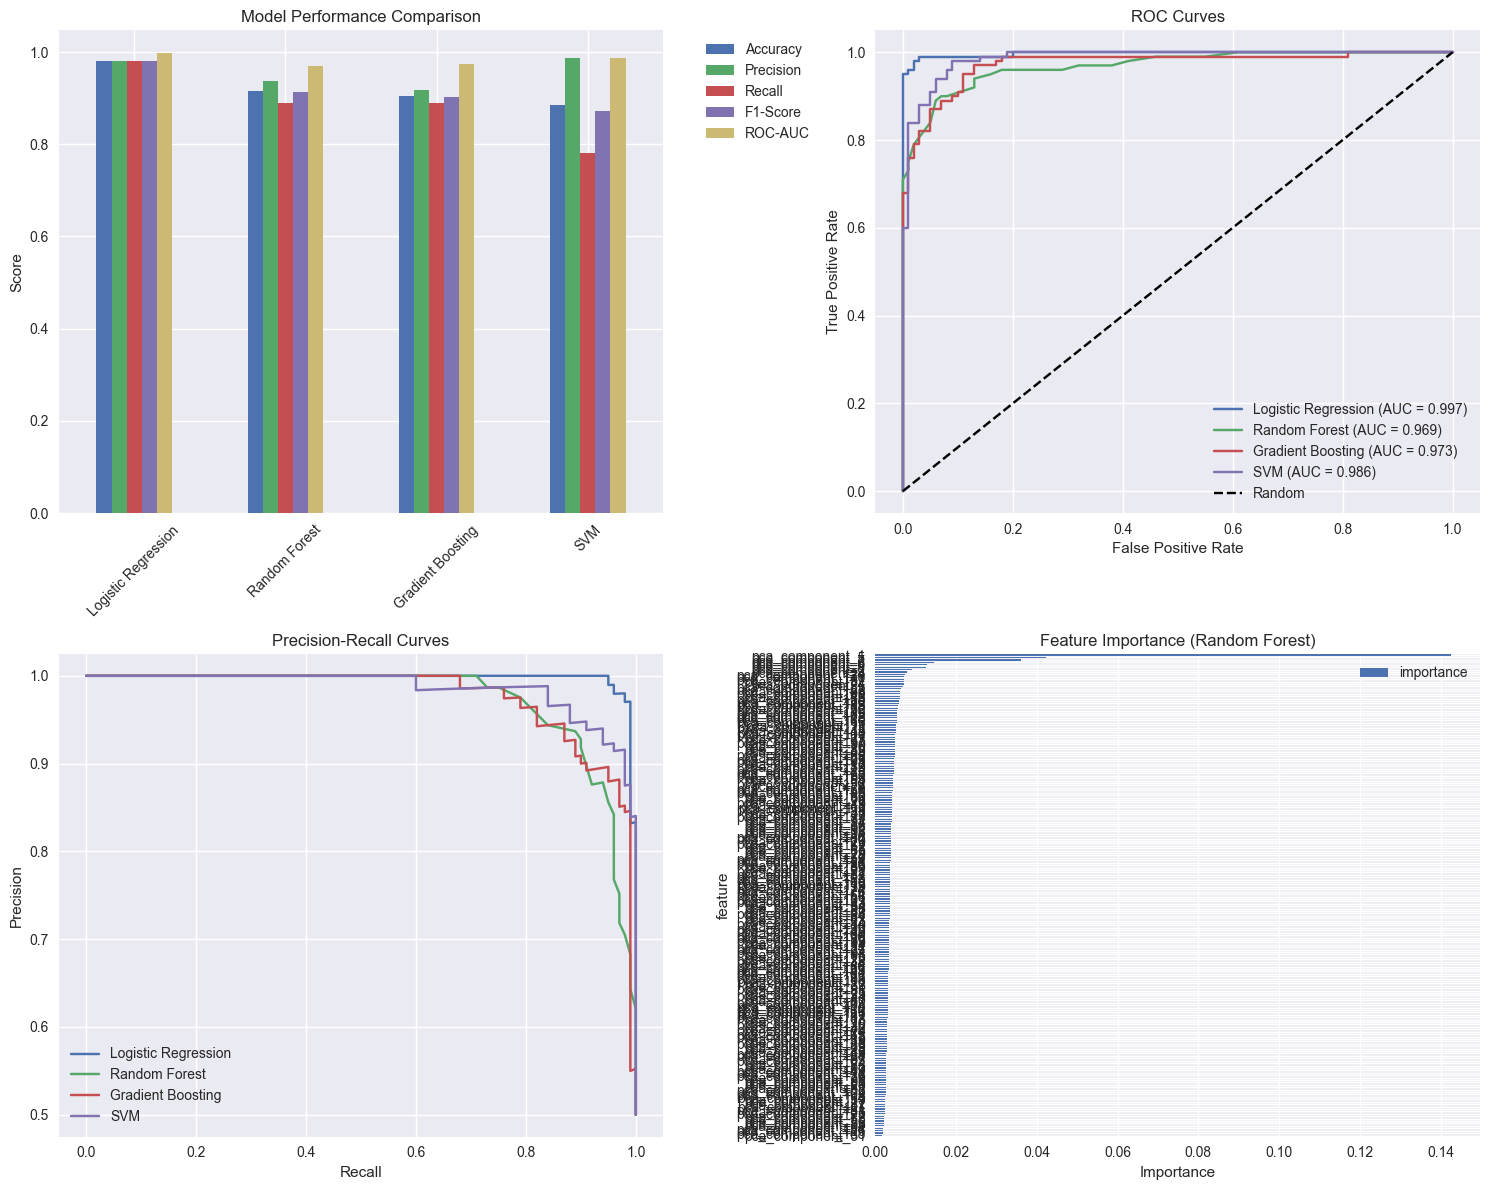

In [40]:
# Visualize model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Metrics comparison
results_df.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].tick_params(axis='x', rotation=45)

# ROC Curves
for name, model in trained_models.items():
    use_scaled = name in ['SVM', 'Logistic Regression']
    test_data = X_test_scaled if use_scaled else X_test
    
    y_pred_proba = model.predict_proba(test_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curves')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision-Recall Curves
for name, model in trained_models.items():
    use_scaled = name in ['SVM', 'Logistic Regression']
    test_data = X_test_scaled if use_scaled else X_test
    
    y_pred_proba = model.predict_proba(test_data)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    
    axes[1, 0].plot(recall, precision, label=name)

axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curves')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Feature importance (for tree-based models)
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    feature_importance.plot(x='feature', y='importance', kind='barh', ax=axes[1, 1])
    axes[1, 1].set_title('Feature Importance (Random Forest)')
    axes[1, 1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

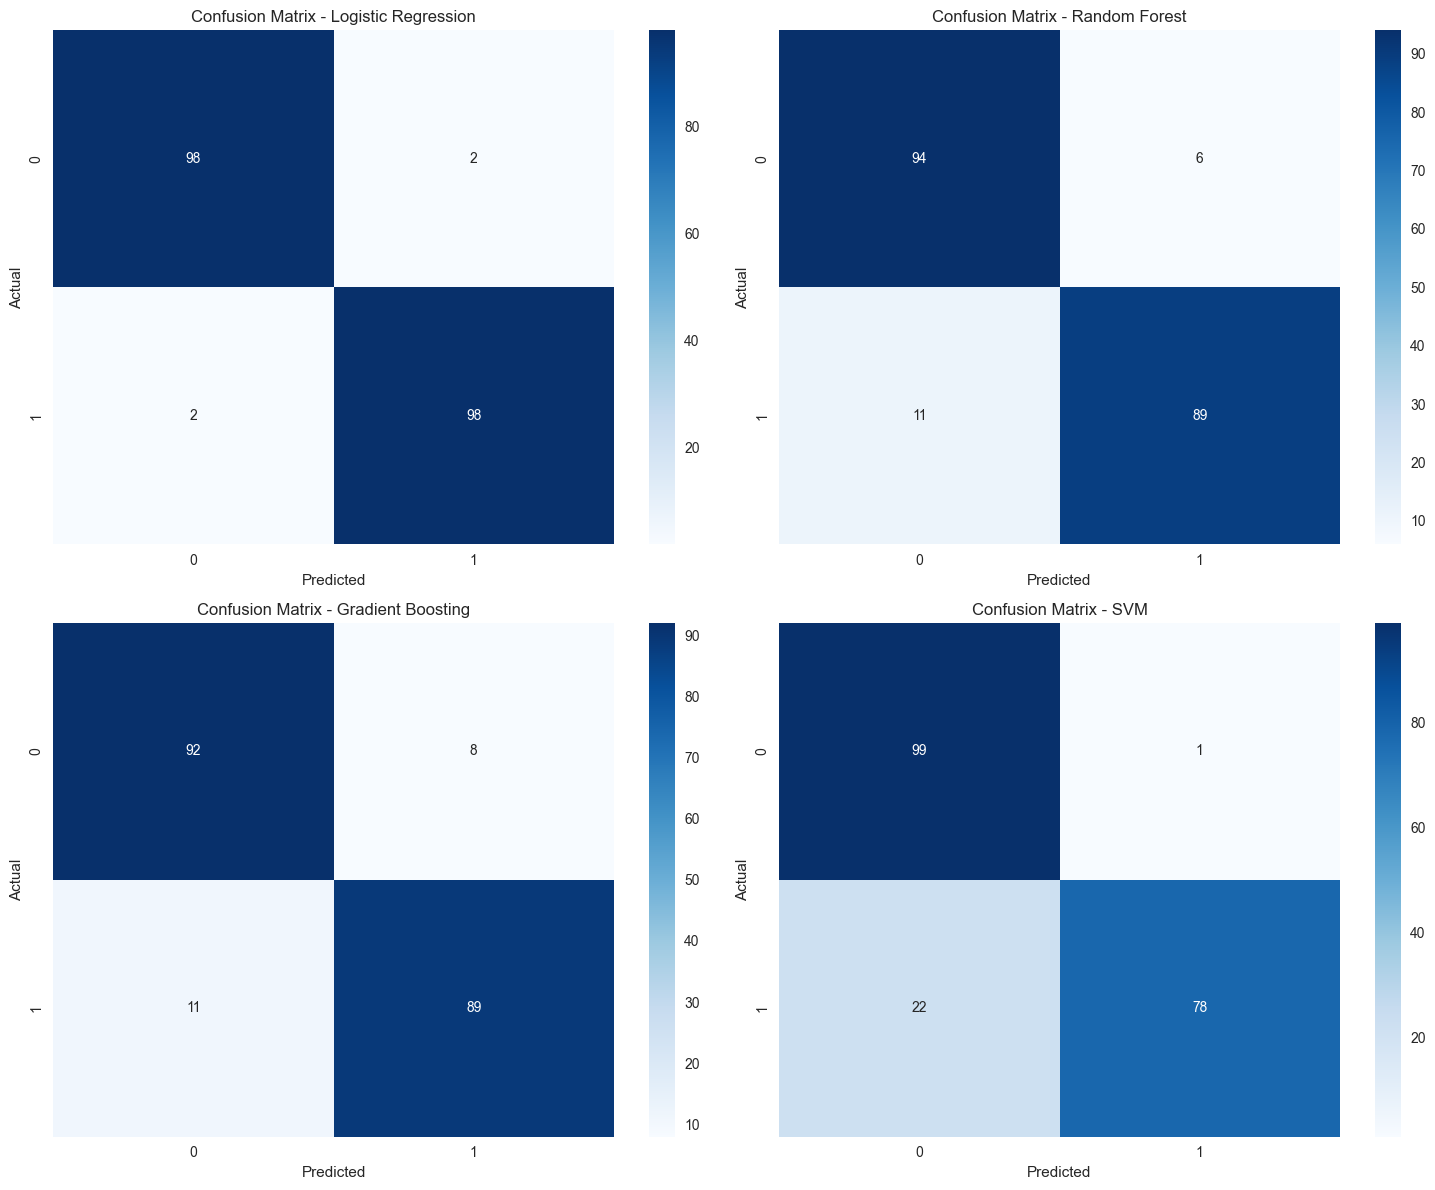

In [41]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, pred_data) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred_data['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [42]:
# Detailed classification reports
for name, pred_data in predictions.items():
    print(f"\n{'='*50}")
    print(f"Classification Report - {name}")
    print(f"{'='*50}")
    print(classification_report(y_test, pred_data['y_pred']))


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       100
           1       0.98      0.98      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       100
           1       0.94      0.89      0.91       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200


Classification Report - Gradient Boosting
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       100
           1       0.92      0.89      0.90       100

    accuracy                           0.91       200
 

## 6. Model Selection and Hyperparameter Tuning

In [43]:
# Select the best model based on F1-score
best_model_name = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['F1-Score'])
best_model = trained_models[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"F1-Score: {evaluation_results[best_model_name]['F1-Score']:.4f}")

# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    print("\nPerforming hyperparameter tuning...")
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")
    
    # Update the best model
    best_model = grid_search.best_estimator_
    trained_models[best_model_name] = best_model

Best performing model: Logistic Regression
F1-Score: 0.9800


## 7. Model Retraining System

In [44]:
# Model retraining and monitoring system
class ModelRetrainingSystem:
    def __init__(self, model, scaler, performance_threshold=0.80):
        self.model = model
        self.scaler = scaler
        self.performance_threshold = performance_threshold
        self.performance_history = []
        self.model_version = 1
        
    def evaluate_performance(self, X_test, y_test):
        """
        Evaluate current model performance
        """
        y_pred = self.model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        
        performance = {
            'timestamp': datetime.now(),
            'f1_score': f1,
            'accuracy': accuracy,
            'model_version': self.model_version
        }
        
        self.performance_history.append(performance)
        return performance
    
    def check_retraining_trigger(self, current_performance):
        """
        Check if model needs retraining
        """
        # Trigger 1: Performance below threshold
        if current_performance['f1_score'] < self.performance_threshold:
            return True, "Performance below threshold"
        
        # Trigger 2: Performance degradation over time
        if len(self.performance_history) >= 3:
            recent_scores = [p['f1_score'] for p in self.performance_history[-3:]]
            if all(recent_scores[i] > recent_scores[i+1] for i in range(len(recent_scores)-1)):
                return True, "Consistent performance degradation"
        
        return False, "No retraining needed"
    
    def retrain_model(self, X_new, y_new, X_val, y_val):
        """
        Retrain the model with new data
        """
        print(f"Retraining model (version {self.model_version + 1})...")
        
        # Create new model instance
        new_model = type(self.model)(**self.model.get_params())
        
        # Retrain
        new_model.fit(X_new, y_new)
        
        # Evaluate new model
        y_pred_new = new_model.predict(X_val)
        new_f1 = f1_score(y_val, y_pred_new)
        
        # Compare with current model
        y_pred_old = self.model.predict(X_val)
        old_f1 = f1_score(y_val, y_pred_old)
        
        if new_f1 > old_f1:
            print(f"New model performs better (F1: {new_f1:.4f} vs {old_f1:.4f})")
            self.model = new_model
            self.model_version += 1
            return True
        else:
            print(f"New model doesn't improve performance. Keeping current model.")
            return False
    
    def save_model(self, filepath):
        """
        Save model and metadata
        """
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'version': self.model_version,
            'performance_history': self.performance_history,
            'timestamp': datetime.now()
        }
        
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load model and metadata
        """
        model_data = joblib.load(filepath)
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.model_version = model_data['version']
        self.performance_history = model_data['performance_history']
        print(f"Model loaded from {filepath}")

# Initialize retraining system
retraining_system = ModelRetrainingSystem(best_model, scaler)

# Evaluate current performance
current_perf = retraining_system.evaluate_performance(X_test, y_test)
print(f"Current model performance: F1={current_perf['f1_score']:.4f}, Accuracy={current_perf['accuracy']:.4f}")

# Check if retraining is needed
needs_retraining, reason = retraining_system.check_retraining_trigger(current_perf)
print(f"Retraining needed: {needs_retraining} - {reason}")

Current model performance: F1=0.9360, Accuracy=0.9350
Retraining needed: False - No retraining needed


In [ ]:
# Save the model and retraining system
model_save_path = '../models/pneumonia_model.pkl'
models_dir = '../models/'
os.makedirs(models_dir, exist_ok=True)

# Save the main model
retraining_system.save_model(model_save_path)

# Also save individual components for flexibility
joblib.dump(best_model, f'{models_dir}/best_model_only.pkl')
joblib.dump(scaler, f'{models_dir}/scaler.pkl')
joblib.dump(X.columns.tolist(), f'{models_dir}/feature_names.pkl')

# Save model performance results
results_df.to_csv(f'{models_dir}/model_evaluation_results.csv')

# Save all trained models for comparison
all_models_path = f'{models_dir}/all_trained_models.pkl'
joblib.dump(trained_models, all_models_path)

print(f"Model artifacts saved successfully!")
print(f" Models directory: {os.path.abspath(models_dir)}")
print(f"  • Main model with retraining system: pneumonia_model.pkl")
print(f"  • Best model only: best_model_only.pkl")
print(f"  • Scaler: scaler.pkl")
print(f"  • Feature names: feature_names.pkl")
print(f"  • Evaluation results: model_evaluation_results.csv")
print(f"  • All models: all_trained_models.pkl")

Model saved to ../models/titanic_model.pkl
Model artifacts saved successfully!
📁 Models directory: c:\Users\HP\Machine-Learning-Cycle\models
  • Main model with retraining system: titanic_model.pkl
  • Best model only: best_model_only.pkl
  • Scaler: scaler.pkl
  • Feature names: feature_names.pkl
  • Evaluation results: model_evaluation_results.csv
  • All models: all_trained_models.pkl


In [ ]:
# Save PCA transformer and feature selector for API use
joblib.dump(pca_transformer, f'{models_dir}/pca_transformer.pkl')
joblib.dump(feature_selector, f'{models_dir}/feature_selector.pkl')

print("Additional model components saved for API:")
print(f"  • PCA transformer: pca_transformer.pkl")
print(f"  • Feature selector: feature_selector.pkl")

✅ Additional model components saved for API:
  • PCA transformer: pca_transformer.pkl
  • Feature selector: feature_selector.pkl


## 8. API Creation for Model Deployment

In [ ]:
# Create API code for model deployment
api_code = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import pandas as pd
import numpy as np
from typing import List
import uvicorn

# Load the trained model
model_data = joblib.load('../models/pneumonia_model.pkl')
model = model_data['model']
scaler = model_data['scaler']

app = FastAPI(title="Pneumonia Detection API", version="1.0.0")

class ImageFeatures(BaseModel):
    features: List[float]  # 200 PCA features

class PredictionResponse(BaseModel):
    pneumonia: int
    probability: float
    confidence: str
    diagnosis: str

@app.get("/")
async def root():
    return {"message": "Pneumonia Detection API"}

@app.get("/health")
async def health_check():
    return {"status": "healthy", "model_version": model_data['version']}

@app.post("/predict", response_model=PredictionResponse)
async def predict_pneumonia(features: ImageFeatures):
    try:
        # Convert input to numpy array
        input_features = np.array(features.features).reshape(1, -1)
        
        # Make prediction
        prediction = model.predict(input_features)[0]
        probability = model.predict_proba(input_features)[0][1]
        
        # Determine confidence level
        if probability > 0.8 or probability < 0.2:
            confidence = "High"
        elif probability > 0.6 or probability < 0.4:
            confidence = "Medium"
        else:
            confidence = "Low"
        
        # Diagnosis
        diagnosis = "PNEUMONIA detected" if prediction == 1 else "NORMAL (no pneumonia)"
        
        return PredictionResponse(
            pneumonia=int(prediction),
            probability=float(probability),
            confidence=confidence,
            diagnosis=diagnosis
        )
    
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.post("/predict_batch")
async def predict_batch(batch_features: List[ImageFeatures]):
    try:
        # Convert input to numpy array
        input_data = np.array([f.features for f in batch_features])
        
        # Make predictions
        predictions = model.predict(input_data)
        probabilities = model.predict_proba(input_data)[:, 1]
        
        results = []
        for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
            if prob > 0.8 or prob < 0.2:
                confidence = "High"
            elif prob > 0.6 or prob < 0.4:
                confidence = "Medium"
            else:
                confidence = "Low"
            
            diagnosis = "PNEUMONIA detected" if pred == 1 else "NORMAL (no pneumonia)"
            
            results.append({
                "image_id": i,
                "pneumonia": int(pred),
                "probability": float(prob),
                "confidence": confidence,
                "diagnosis": diagnosis
            })
        
        return {"predictions": results}
    
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

@app.get("/model_info")
async def model_info():
    return {
        "model_type": type(model).__name__,
        "model_version": model_data['version'],
        "last_updated": str(model_data['timestamp']),
        "dataset": "Chest X-Ray Pneumonia Detection",
        "features": "200 PCA components from 150x150 grayscale images",
        "classes": {"0": "NORMAL", "1": "PNEUMONIA"}
    }

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Save API code to file
with open('../src/api.py', 'w') as f:
    f.write(api_code)

print("API code saved to ../src/api.py")
print("\nTo run the API:")
print("1. Navigate to the src directory")
print("2. Run: python api.py")
print("3. Access the API at http://localhost:8000")
print("4. View interactive docs at http://localhost:8000/docs")

API code saved to ../src/api.py

To run the API:
1. Navigate to the src directory
2. Run: python api.py
3. Access the API at http://localhost:8000
4. View interactive docs at http://localhost:8000/docs


In [47]:
# Create a simple test client for the API
test_client_code = '''
import requests
import json

# API endpoint
API_URL = "http://localhost:8000"

def test_api():
    # Test health check
    response = requests.get(f"{API_URL}/health")
    print("Health check:", response.json())
    
    # Test single prediction
    passenger_data = {
        "Pclass": 3,
        "Sex": 1,  # male
        "Age": 25.0,
        "SibSp": 0,
        "Parch": 0,
        "Fare": 8.0,
        "Embarked": 0,  # S
        "FamilySize": 1,
        "IsAlone": 1,
        "Title": 1,  # Mr
        "AgeGroup": 2,  # Adult
        "FareGroup": 0  # Low
    }
    
    response = requests.post(f"{API_URL}/predict", json=passenger_data)
    print("Single prediction:", response.json())
    
    # Test model info
    response = requests.get(f"{API_URL}/model_info")
    print("Model info:", response.json())

if __name__ == "__main__":
    test_api()
'''

# Save test client code
with open('../src/test_api.py', 'w') as f:
    f.write(test_client_code)

print("Test client saved to ../src/test_api.py")

Test client saved to ../src/test_api.py
